In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy import signal
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
#Defining Machine parameters 
mach_mc = {"rs": 0.031, "lq": 0.076, "ld": 0.076, "tmech":80, "psi_rm":0.0204}

###  The Machine Parameters
We use machine dictionaries to calculate the various parameters used in space vector based machine model This function is called mach_para(dict)

In [3]:
def mach_para(mach):
    """Takes in the dictionary containing machine parameters (normalized)
       and returns various parameters that are used in space vector equations
       
       Takes arguement: machine dictionary
       """
    rs = mach["rs"]
    ld = mach['ld']
    lq = mach['lq']
#     ws = mach['ws']
#     sig= 1-(lh*lh)/(lr*ls)
#     kr=lh/lr
#     sigls=sig*ls
#     tr=lr/rr
#     rk=(rs+(kr)*(kr)*rr)
#     tk=sigls/(rs+(kr)*(kr)*rr)
    tmech = mach['tmech']
    psi_rm = mach['psi_rm']
#     print("lh = {0:1.3f}".format(lh))
#     return rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech
    return rs, ld, lq, tmech, psi_rm

In [4]:
mach_para(mach_mc)

(0.031, 0.076, 0.076, 80, 0.0204)

### PMSM Dynamics
#### Building the Dynamic Model of a PMSM in the d-q Coordinate
To model a PMSM, two state variables are chosen, which are $i_{s}$ and $\omega_{s}$. The $i_{s}$ can be further decomposed to $i_{sd}$, $i_{sq}$ in the permanant magnetic field since it is a complex space vector. The differential equations of these vectors are given as:

\begin{align}
\frac{di_{sd}}{d\tau}&= -\frac{r_{s}}{l_{d}}i_{sd} + \omega_{s} \frac{l_q}{l_d}i_{sq} + \frac{v_{sd}}{l_d}\\
\frac{di_{sq}}{d\tau}&= - \omega_{s} \frac{l_d}{l_q}i_{sd} -\frac{r_{s}}{l_{q}}i_{sq}  - \omega_{s} \frac{\psi_{r,m}}{l_q} + \frac{v_{sq}}{l_q}\\
\frac{d\omega_s}{d\tau}&= \frac{1}{\tau_{mech}}\left[m_e - m_L\right], m_e = \psi_{r,m}i_{sq}+(l_d-l_q)i_{sd}i_{sq}
\end{align}


In [5]:
#Induction machine 5x5 dynamic model 

def IM_dynstep(X,t,params):
    """Defines a function to calculate the derivatives for a 5x5 Induction motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0] #isd
    x1 = X[1] #isq
    ws = X[2] # w
#     x2 = X[2]  #psiralpha
#     x3 = X[3]  #psirbeta
#     x4 = X[4]  #w
#     wx = X[5]
#     u1,u2,m_l,w_s,psi_rm, l_d, l_q = params
    u1,u2,m_l,w_s = params
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     print("u1:")
#     print(u1)
    
    A,B,C,D,tm = mach_imstep(mach_mc, params)
#     print("B[0]:")
#     print(B[0])
    m_diff = (psi_rm*x0+(l_d-l_q)*x0*x1) - m_l
    dx0_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[0][0]*u1)
    dx1_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[1][0]*(-w_s*psi_rm+u2))
    dx2_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[2][0]*m_diff)
#     print(A[1][0],A[1][1],A[1][2],A[1][3],B[4][0])
#     dx0dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*x2 + A[0][3]*x3*x4 + A[0][4]*x4 + B[0][0]*u1)
#     dx1dt = (A[1][0]*x0 + A[1][1]*x1 + A[1][2]*x2*x4 + A[1][3]*x3 + A[1][4]*x4 + B[1][0]*u2)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dx2dt = (A[2][0]*x0 + A[2][1]*x1 + A[2][2]*x2 + A[2][3]*x3*x4 + A[2][4]*x4 + 0)
#     dx3dt = (A[3][0]*x0 + A[3][1]*x1 + A[3][2]*x2*x4 + A[3][3]*x3 + A[3][4]*x4 + 0)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dwxdt = rate
    return [dx0_dt,dx1_dt,dx2_dt]


def mach_imstep(mc_dict, params):
    """
    Define the induction model that is a 3x3 matrix. 
    1. The current components are $i_s\alpha + ji_{s \beta}$. 
    2. The rotor flux components are $\psi_{s\alpha} + j\psi_{s\beta}$ and $\omega$
    3. Needs machine dictionary as input
    4. does not use $\omega_s$ in this function, it will be multipied in the derivative function
    """
    u1,u2,m_l,ws = params
#     rs,rr,ld,lq,sig,kr,tr,rk,tk,tmech = mach_para(mc_dict)
    rs,ld,lq, tmech, psi_rm = mach_para(mc_dict)
    a11 = -(rs/ld)
    a12 = ((ws*lq)/ld)
    a13 = 0
#     a14 = (kr/(sig*ls))   #has to be multiplied by omega
#     a15 = 0


    a21 = -((ld*ws)/lq)
    a22 = -rs/lq
    a23 = 0
#     a24 = a13
#     a25 = 0

    a31 = 0
    a32 = 0 
    a33 = 0

    b11 = 1/(ld)
    b21 = 1/(lq)
    b31 = 1/(tmech)
#     b41 = 0
#     b51 = 1/(tmech)
    

    c11 = 1.0
    c22 = 1.0
    c33 = 1.0
#     c44 = 1.0
#     c55 = 1.0

    A = ([a11,a12,a13],[a21,a22,a23],[a31,a32,a33])
    B = ([b11], [b21], [b31])
    C = ([c11, c22, c33])
    D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     C=([c11,0,0],[0,c22,0],[0,0,c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     A=([a11,a12,a13,a14,a15],[a21,a22,a23,a24,a25],[a31,a32,a33,a34,a35],[a41,a42,a43,a44,a45,[a51,a52,a53,a54,a55])
#     B=([b11,0],[b21,0],[b31,0],[b41,0],[b51,0])
#     C=([c11,0,0,0,0],[0,c22,0,0,0],[0,0,c33,0,0],[0,0,0,c44,0],[0,0,0,0,a55])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
    
    return A, B, C, D, tmech

In [6]:
#Rotor dynamics as mechanics
def rotor_dyndq(X,t,params):
    w = X[0]
    gamma = X[1] #rotor angle
    
    me,mL,tmech = params
    dwdt = (me-mL)/tmech
    dgammadt = w
    return [dwdt, dgammadt]
    

In [7]:
#Function for rotor angle integration 
# d\delta/dt = w

def rotorangle(X,t,params):
    del0 = X
    w = params
    ddel0dt = w
    return ddel0dt

In [8]:
def PIcon(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    return y2

def PIconwithLim(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti, uplim, dwnlim = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
#     y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    yx = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    if (yx > uplim):
        yx = uplim
    elif (yx < dwnlim):
        yx = dwnlim
    y2 = yx
    return y2

## 1. System Dynamics without Control

## 2. System Dynamics with Control

## 3. Controlling the System by Vector Control to Speed up, Keep Steady Speed, and Slowing Down $\omega_s$

In [9]:
#Induction machine 5x5 dynamic model 

def PMSM_dynStep2By2(X,t,params):
    """Defines a function to calculate the derivatives for a 5x5 Induction motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0] #isd
    x1 = X[1] #isq
#     x2 = X[2]  #psiralpha
#     x3 = X[3]  #psirbeta
#     x4 = X[4]  #w
#     wx = X[5]
#     u1,u2,m_l,w_s,psi_rm, l_d, l_q = params
    u1,u2,m_l,w_s = params
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     print("u1:")
#     print(u1)
    
    A,B,C,D,tm = mach_PMSMStep2By2(mach_mc, params)
#     print("B[0]:")
#     print(B[0])
    m_diff = (psi_rm*x0+(l_d-l_q)*x0*x1) - m_l
    dx0_dt = (A[0][0]*x0 + A[0][1]*x1 + B[0][0]*u1)
    dx1_dt = (A[0][0]*x0 + A[0][1]*x1+ B[1][0]*(-w_s*psi_rm+u2))
#     dx2_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[2][0]*m_diff)

    return [dx0_dt,dx1_dt]


def mach_PMSMStep2By2(mc_dict, params):
    u1,u2,m_l,ws = params
#     rs,rr,ld,lq,sig,kr,tr,rk,tk,tmech = mach_para(mc_dict)
    rs,ld,lq, tmech, psi_rm = mach_para(mc_dict)
    a11 = -(rs/ld)
    a12 = ((ws*lq)/ld)
#     a13 = 0
#     a14 = (kr/(sig*ls))   #has to be multiplied by omega
#     a15 = 0


    a21 = -((ld*ws)/lq)
    a22 = -rs/lq
#     a23 = 0
#     a24 = a13
#     a25 = 0

    a31 = 0
    a32 = 0 
#     a33 = 0

    b11 = 1/(ld)
    b21 = 1/(lq)
#     b31 = 1/(tmech)
#     b41 = 0
#     b51 = 1/(tmech)
    

    c11 = 1.0
    c22 = 1.0
#     c33 = 1.0
#     c44 = 1.0
#     c55 = 1.0
    A = ([a11,a12],[a21,a22],[a31,a32])
    B = ([b11], [b21])
    C = ([c11, c22])
    D= ([0,0],[0,0])
#     A = ([a11,a12,a13],[a21,a22,a23],[a31,a32,a33])
#     B = ([b11], [b21], [b31])
#     C = ([c11, c22, c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     C=([c11,0,0],[0,c22,0],[0,0,c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     A=([a11,a12,a13,a14,a15],[a21,a22,a23,a24,a25],[a31,a32,a33,a34,a35],[a41,a42,a43,a44,a45,[a51,a52,a53,a54,a55])
#     B=([b11,0],[b21,0],[b31,0],[b41,0],[b51,0])
#     C=([c11,0,0,0,0],[0,c22,0,0,0],[0,0,c33,0,0],[0,0,0,c44,0],[0,0,0,0,a55])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
    
    return A, B, C, D, tmech

In [10]:
#Rotor dynamics as mechanics
def rotor_dyndq(X,t,params):
    w = X[0]
    gamma = X[1] #rotor angle
    
    me,mL,tmech = params
    dwdt = (me-mL)/tmech
    dgammadt = w
    return [dwdt, dgammadt]

    if w < -zeroThresh:
        # a > 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = 0.85
            isq = -1
        else:
            isd = -0.85
            isq = -1
    else:
        # a < 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = -0.85
            isq = -1
        else:
            isd = 0.85
            isq = -1

In [11]:
# zeroThresh = 0.0005
# def calculateIsdIsqRefsBySpeedSimple(w, isSlowingDown):
#     isd, isq = 0.0, 0.0
#     a = 0.0199
#     ml = 0.0
#     if w < -zeroThresh:
#         # a > 0 to slow down, # a < 0 to speed up:
#         if(isSlowingDown == 1):
#             isd = -1 # a = 0.0199
#             isq = 0.85
#         else:
#             isd = -1 # a = -0.0199
#             isq = -0.85
#     else:
#         # a < 0 to slow down, # a > 0 to speed up:
#         if(isSlowingDown == 1):
#             isd = -1
#             isq = -0.85
#         else:
#             isd = -1
#             isq = 0.85
# #     else:
# #         isd, isq = 0.0, 0.0
# #     if isSlowingDown < 0:
# #         # slowing down:
# #         isd = 0.5
# #         isq = -0.09
# #     else:
# #         # speeding up
# #         isd = 0.2
# #         isq = 0.105
#     print("calculate isd, isq:")
#     print(isd, isq)
#     return isd, isq
        

In [95]:
zeroThresh = 0.0005
def calculateIsdIsqRefsBySpeedSimple(w, isSlowingDown):
    isd, isq = 0.0, 0.0
    a = 0.002
    ml = 0.0
    if w < -zeroThresh:
        # a > 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = 0.2
            isq = 0.105
        else:
            isd = 0.5
            isq = -0.09
    else:
        # a < 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = 0.6
            isq = -0.5
        else:
            isd = 0.8 # speed up
            isq = 0.7
    print("calculate isd, isq:")
    print(isd, isq)
    return isd, isq

In [96]:
def braking(w, isSlowingDown):
    print("in braking")
    print(w)
    isd, isq = 0.0, 0.0
    if(abs(w) <= zeroThresh):
        isd, isq = 0.0, 0.0
    else:
        isd, isq = calculateIsdIsqRefsBySpeedSimple(w, 1)
    print("braking: isd, isq:")
    print(isd, isq)
    return isd, isq

In [103]:
def simulateSpeedingUpWithAcceleration():
    #Setting up the simulaton for rotor model
    # We will use for loop for simulation 
    rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
    tend = 45*3*np.pi
    tstart = 0.0
    delta_t = 0.01
    Tta = np.arange(tstart, tend,delta_t)
    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-3
    
    n = 100000
#     n2 = int(100*2*np.pi/0.01)
    # ws = -0.5
    ws = -0.5
    mL = 0.0
    # Tta = np.linspace(tstart, tend, n2)
    #delta_t = Tta[1] - Tta[0]
    usd = np.zeros(len(Tta))
    usq = np.zeros(len(Tta))
    sol1 = np.zeros((len(Tta),2))
    sol2 = np.zeros((len(Tta),2))
    FCangle = np.zeros(len(Tta))
    gamma = np.zeros(len(Tta)) # rotor angle
    # Field coordinate currents
    cosdelta = np.zeros(len(Tta))
    sindelta = np.zeros(len(Tta))
    isd = np.zeros(len(Tta))
    isq = np.zeros(len(Tta))
    eid = np.zeros(len(Tta))
    eiq = np.zeros(len(Tta))
    w = np.zeros(len(Tta))

    me = np.zeros(len(Tta))
    x0 = [0,0] # isd, isq, ws
    y0 = [0,0] # w, angle

    kpd = ld*1
    Tid = 25.0e1

    kpq = lq*2
    Tiq = 25.0e1

    Kparamsd = [kpd,Tid]
    Kparamsq = [kpq,Tiq]
    flag = 0
    
    wrefs = np.ones(len(Tta))
    twoThirdLenTta = int(2*len(Tta)/3)
    wrefs[twoThirdLenTta:len(Tta)] = np.zeros((len(Tta)-twoThirdLenTta))
    wrefs = wrefs*0.8

#     for ii in range(0, len(Tta))
    ii =0
    isdref = 0.0
    isqref = 0.0
    isdrefs = [isdref]
    isqrefs = [isqref]
    endOfStablization = 0
    while(ii < len(Tta)):
        #Start controller after first step
        if ii>=0:
            eid[ii] = isdref - isd[ii-1]
            PIed = [eid[ii],eid[ii-1]]
            usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
            eiq[ii] = isqref - isq[ii-1]
            PIeq = [eiq[ii],eiq[ii-1]]
            usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

        # solve for the state variables: isd, isq
        params = [usd[ii], usq[ii],w[ii], ws]
        sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
        sol1[ii]= sol1a[-1]
        x0 = sol1a[-1]
        isd[ii] = sol1[ii][0]
        isq[ii] = sol1[ii][1]
        # solve for w:
        me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
        paramsw = [me[ii],0.0,tmech]
        sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
        y0 = sol2a[-1]
        sol2[ii] = sol2a[-1]
        FCangle[ii] = sol2[ii][1]
        gamma[ii] = sol2[ii][1]
        w[ii] = sol2[ii][0]
#         TtaEnd = Tta[ii]
        print("w[ii]:")
        print(ii, Tta[ii], w[ii])
        print("New")
        if(ii < len(Tta) and w[ii] < wrefs[ii]-0.005):
            print("Speeding up from:")
            print(Tta[ii])
            isdref, isqref = calculateIsdIsqRefsBySpeedSimple(wrefs[ii], 0)
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        elif(ii < len(Tta) and w[ii] > wrefs[ii]+0.005):
            print("Before Braking: w:")
            print(w[ii])
            print(Tta[ii])
            isdref, isqref = calculateIsdIsqRefsBySpeedSimple(wrefs[ii], 1)
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        else:
            print("Uniform speed from:")
            print(Tta[ii])
            isdref = 0
            isqref = 0
            isdrefs.append(isdref)
            isqrefs.append(isqref)
#         if(ii < len(Tta) and Tta[ii] >= 2*np.pi and Tta[ii] < 15*np.pi):
#             print("Speeding up from:")
#             print(Tta[ii])
#             isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 0)
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
#         elif(ii < len(Tta) and Tta[ii] >= 15*np.pi and Tta[ii] < 35*np.pi):
#             print("Uniform speed from:")
#             print(Tta[ii])
#             isdref = 0
#             isqref = 0
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
#         else:
#             print("Before Braking: w:")
#             print(w[ii])
#             print(Tta[ii])
#             isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 1)
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
        ii += 1
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
    return Tta, w[0:len(Tta)], me[0:len(Tta)], isd[0:len(Tta)], isq[0:len(Tta)], np.array(isdrefs)[0:len(Tta)], np.array(isqrefs)[0:len(Tta)]

In [104]:
# import matplotlib.pyplot as pl
# %matplotlib inline
def plotDynamicForSpeedingUp(Tta, w1, me1, isd1, isq1, isdref, isqref):
    pl.figure(531, figsize = (6,6))
    pl.rc('font', size = 16)
    # plot the isd and isq
    pl.subplot(2,1,1)
    pl.plot(Tta,  isd, 'purple', Tta, isdref,'skyblue', lw=3)
    pl.plot(Tta, isqref,'tomato', Tta,isq ,'crimson' ,lw =2)

    pl.xlim(0,Tta[-1])
    pl.ylabel(r'$isd, isq$' )
    pl.xticks(np.linspace(0,Tta[-1],5))

    ax1 = pl.subplot(2,1,2)
    ax1.axhline(0)
    ax1.plot(Tta, me1, 'crimson', lw =2)
    ax1.set_yticks(np.linspace(-1.0,1.0,5))
    ax1.set_ylabel('me [p.u]')
    ax2 = ax1.twinx()
    ax2.set_ylabel('$\omega$')
    ax2.plot(Tta,w, 'peru', lw =3)

w[ii]:
0 0.0 1.673454788521508e-07
New
Speeding up from:
0.0
calculate isd, isq:
0.8 0.7
w[ii]:
1 0.01 2.2484335750230485e-06
New
Speeding up from:
0.01
calculate isd, isq:
0.8 0.7
w[ii]:
2 0.02 6.1984073380667165e-06
New
Speeding up from:
0.02
calculate isd, isq:
0.8 0.7
w[ii]:
3 0.03 1.1973407780554307e-05
New
Speeding up from:
0.03
calculate isd, isq:
0.8 0.7
w[ii]:
4 0.04 1.9530596813521154e-05
New
Speeding up from:
0.04
calculate isd, isq:
0.8 0.7
w[ii]:
5 0.05 2.8828134638309456e-05
New
Speeding up from:
0.05
calculate isd, isq:
0.8 0.7
w[ii]:
6 0.06 3.982515710919876e-05
New
Speeding up from:
0.06
calculate isd, isq:
0.8 0.7
w[ii]:
7 0.07 5.248175341299828e-05
New
Speeding up from:
0.07
calculate isd, isq:
0.8 0.7
w[ii]:
8 0.08 6.675894412334037e-05
New
Speeding up from:
0.08
calculate isd, isq:
0.8 0.7
w[ii]:
9 0.09 8.261865967418899e-05
New
Speeding up from:
0.09
calculate isd, isq:
0.8 0.7
w[ii]:
10 0.1 0.00010002371927635579
New
Speeding up from:
0.1
calculate isd, isq:
0.8 

w[ii]:
252 2.52 0.017117064293909478
New
Speeding up from:
2.52
calculate isd, isq:
0.8 0.7
w[ii]:
253 2.5300000000000002 0.01719793448629507
New
Speeding up from:
2.5300000000000002
calculate isd, isq:
0.8 0.7
w[ii]:
254 2.54 0.01727881076275359
New
Speeding up from:
2.54
calculate isd, isq:
0.8 0.7
w[ii]:
255 2.5500000000000003 0.017359693068345512
New
Speeding up from:
2.5500000000000003
calculate isd, isq:
0.8 0.7
w[ii]:
256 2.56 0.017440581350615925
New
Speeding up from:
2.56
calculate isd, isq:
0.8 0.7
w[ii]:
257 2.57 0.017521475559530465
New
Speeding up from:
2.57
calculate isd, isq:
0.8 0.7
w[ii]:
258 2.58 0.017602375647412655
New
Speeding up from:
2.58
calculate isd, isq:
0.8 0.7
w[ii]:
259 2.59 0.017683281568882752
New
Speeding up from:
2.59
calculate isd, isq:
0.8 0.7
w[ii]:
260 2.6 0.01776419328079799
New
Speeding up from:
2.6
calculate isd, isq:
0.8 0.7
w[ii]:
261 2.61 0.01784511074219421
New
Speeding up from:
2.61
calculate isd, isq:
0.8 0.7
w[ii]:
262 2.62 0.017926033914

710 7.1000000000000005 0.054905722436462676
New
Speeding up from:
7.1000000000000005
calculate isd, isq:
0.8 0.7
w[ii]:
711 7.11 0.054990112490205065
New
Speeding up from:
7.11
calculate isd, isq:
0.8 0.7
w[ii]:
712 7.12 0.05507451006636911
New
Speeding up from:
7.12
calculate isd, isq:
0.8 0.7
w[ii]:
713 7.13 0.05515891515264554
New
Speeding up from:
7.13
calculate isd, isq:
0.8 0.7
w[ii]:
714 7.140000000000001 0.05524332773670279
New
Speeding up from:
7.140000000000001
calculate isd, isq:
0.8 0.7
w[ii]:
715 7.15 0.055327747806187405
New
Speeding up from:
7.15
calculate isd, isq:
0.8 0.7
w[ii]:
716 7.16 0.055412175348724335
New
Speeding up from:
7.16
calculate isd, isq:
0.8 0.7
w[ii]:
717 7.17 0.05549661035191737
New
Speeding up from:
7.17
calculate isd, isq:
0.8 0.7
w[ii]:
718 7.18 0.05558105280334942
New
Speeding up from:
7.18
calculate isd, isq:
0.8 0.7
w[ii]:
719 7.19 0.05566550269058296
New
Speeding up from:
7.19
calculate isd, isq:
0.8 0.7
w[ii]:
720 7.2 0.05574996000116035
New


Speeding up from:
9.72
calculate isd, isq:
0.8 0.7
w[ii]:
973 9.73 0.07732111842479618
New
Speeding up from:
9.73
calculate isd, isq:
0.8 0.7
w[ii]:
974 9.74 0.07740704867578813
New
Speeding up from:
9.74
calculate isd, isq:
0.8 0.7
w[ii]:
975 9.75 0.07749298319116421
New
Speeding up from:
9.75
calculate isd, isq:
0.8 0.7
w[ii]:
976 9.76 0.07757892196021626
New
Speeding up from:
9.76
calculate isd, isq:
0.8 0.7
w[ii]:
977 9.77 0.0776648649722557
New
Speeding up from:
9.77
calculate isd, isq:
0.8 0.7
w[ii]:
978 9.78 0.0777508122166135
New
Speeding up from:
9.78
calculate isd, isq:
0.8 0.7
w[ii]:
979 9.790000000000001 0.07783676368264016
New
Speeding up from:
9.790000000000001
calculate isd, isq:
0.8 0.7
w[ii]:
980 9.8 0.07792271935970582
New
Speeding up from:
9.8
calculate isd, isq:
0.8 0.7
w[ii]:
981 9.81 0.07800867923720022
New
Speeding up from:
9.81
calculate isd, isq:
0.8 0.7
w[ii]:
982 9.82 0.07809464330453274
New
Speeding up from:
9.82
calculate isd, isq:
0.8 0.7
w[ii]:
983 9.83 0

w[ii]:
1381 13.81 0.11263640872636232
New
Speeding up from:
13.81
calculate isd, isq:
0.8 0.7
w[ii]:
1382 13.82 0.11272340303826346
New
Speeding up from:
13.82
calculate isd, isq:
0.8 0.7
w[ii]:
1383 13.83 0.11281039876164672
New
Speeding up from:
13.83
calculate isd, isq:
0.8 0.7
w[ii]:
1384 13.84 0.11289739589256564
New
Speeding up from:
13.84
calculate isd, isq:
0.8 0.7
w[ii]:
1385 13.85 0.11298439442708473
New
Speeding up from:
13.85
calculate isd, isq:
0.8 0.7
w[ii]:
1386 13.86 0.11307139436127928
New
Speeding up from:
13.86
calculate isd, isq:
0.8 0.7
w[ii]:
1387 13.870000000000001 0.1131583956912354
New
Speeding up from:
13.870000000000001
calculate isd, isq:
0.8 0.7
w[ii]:
1388 13.88 0.11324539841305004
New
Speeding up from:
13.88
calculate isd, isq:
0.8 0.7
w[ii]:
1389 13.89 0.1133324025228309
New
Speeding up from:
13.89
calculate isd, isq:
0.8 0.7
w[ii]:
1390 13.9 0.11341940801669645
New
Speeding up from:
13.9
calculate isd, isq:
0.8 0.7
w[ii]:
1391 13.91 0.11350641489077581


w[ii]:
1751 17.51 0.14489458643786388
New
Speeding up from:
17.51
calculate isd, isq:
0.8 0.7
w[ii]:
1752 17.52 0.14498190625357765
New
Speeding up from:
17.52
calculate isd, isq:
0.8 0.7
w[ii]:
1753 17.53 0.1450692265697114
New
Speeding up from:
17.53
calculate isd, isq:
0.8 0.7
w[ii]:
1754 17.54 0.1451565473848736
New
Speeding up from:
17.54
calculate isd, isq:
0.8 0.7
w[ii]:
1755 17.55 0.14524386869767658
New
Speeding up from:
17.55
calculate isd, isq:
0.8 0.7
w[ii]:
1756 17.56 0.14533119050673637
New
Speeding up from:
17.56
calculate isd, isq:
0.8 0.7
w[ii]:
1757 17.57 0.14541851281067297
New
Speeding up from:
17.57
calculate isd, isq:
0.8 0.7
w[ii]:
1758 17.580000000000002 0.14550583560810992
New
Speeding up from:
17.580000000000002
calculate isd, isq:
0.8 0.7
w[ii]:
1759 17.59 0.14559315889767468
New
Speeding up from:
17.59
calculate isd, isq:
0.8 0.7
w[ii]:
1760 17.6 0.14568048267799846
New
Speeding up from:
17.6
calculate isd, isq:
0.8 0.7
w[ii]:
1761 17.61 0.1457678069477161
N

Speeding up from:
20.46
calculate isd, isq:
0.8 0.7
w[ii]:
2047 20.47 0.17075818271187315
New
Speeding up from:
20.47
calculate isd, isq:
0.8 0.7
w[ii]:
2048 20.48 0.17084560353989856
New
Speeding up from:
20.48
calculate isd, isq:
0.8 0.7
w[ii]:
2049 20.490000000000002 0.1709330245873714
New
Speeding up from:
20.490000000000002
calculate isd, isq:
0.8 0.7
w[ii]:
2050 20.5 0.17102044585368245
New
Speeding up from:
20.5
calculate isd, isq:
0.8 0.7
w[ii]:
2051 20.51 0.17110786733822425
New
Speeding up from:
20.51
calculate isd, isq:
0.8 0.7
w[ii]:
2052 20.52 0.171195289040391
New
Speeding up from:
20.52
calculate isd, isq:
0.8 0.7
w[ii]:
2053 20.53 0.17128271095957853
New
Speeding up from:
20.53
calculate isd, isq:
0.8 0.7
w[ii]:
2054 20.54 0.17137013309518445
New
Speeding up from:
20.54
calculate isd, isq:
0.8 0.7
w[ii]:
2055 20.55 0.17145755544660798
New
Speeding up from:
20.55
calculate isd, isq:
0.8 0.7
w[ii]:
2056 20.56 0.17154497801325003
New
Speeding up from:
20.56
calculate isd, 

New
Speeding up from:
22.39
calculate isd, isq:
0.8 0.7
w[ii]:
2240 22.400000000000002 0.18763383569076986
New
Speeding up from:
22.400000000000002
calculate isd, isq:
0.8 0.7
w[ii]:
2241 22.41 0.18772128934682789
New
Speeding up from:
22.41
calculate isd, isq:
0.8 0.7
w[ii]:
2242 22.42 0.18780874313127371
New
Speeding up from:
22.42
calculate isd, isq:
0.8 0.7
w[ii]:
2243 22.43 0.1878961970437515
New
Speeding up from:
22.43
calculate isd, isq:
0.8 0.7
w[ii]:
2244 22.44 0.18798365108390636
New
Speeding up from:
22.44
calculate isd, isq:
0.8 0.7
w[ii]:
2245 22.45 0.18807110525138443
New
Speeding up from:
22.45
calculate isd, isq:
0.8 0.7
w[ii]:
2246 22.46 0.18815855954583283
New
Speeding up from:
22.46
calculate isd, isq:
0.8 0.7
w[ii]:
2247 22.47 0.18824601396689955
New
Speeding up from:
22.47
calculate isd, isq:
0.8 0.7
w[ii]:
2248 22.48 0.18833346851423374
New
Speeding up from:
22.48
calculate isd, isq:
0.8 0.7
w[ii]:
2249 22.490000000000002 0.18842092318748538
New
Speeding up from:


0.8 0.7
w[ii]:
2510 25.1 0.211249958441527
New
Speeding up from:
25.1
calculate isd, isq:
0.8 0.7
w[ii]:
2511 25.11 0.21133743603534738
New
Speeding up from:
25.11
calculate isd, isq:
0.8 0.7
w[ii]:
2512 25.12 0.21142491369228206
New
Speeding up from:
25.12
calculate isd, isq:
0.8 0.7
w[ii]:
2513 25.13 0.21151239141218126
New
Speeding up from:
25.13
calculate isd, isq:
0.8 0.7
w[ii]:
2514 25.14 0.21159986919489482
New
Speeding up from:
25.14
calculate isd, isq:
0.8 0.7
w[ii]:
2515 25.150000000000002 0.21168734704027217
New
Speeding up from:
25.150000000000002
calculate isd, isq:
0.8 0.7
w[ii]:
2516 25.16 0.21177482494816247
New
Speeding up from:
25.16
calculate isd, isq:
0.8 0.7
w[ii]:
2517 25.17 0.21186230291841457
New
Speeding up from:
25.17
calculate isd, isq:
0.8 0.7
w[ii]:
2518 25.18 0.21194978095087694
New
Speeding up from:
25.18
calculate isd, isq:
0.8 0.7
w[ii]:
2519 25.19 0.21203725904539786
New
Speeding up from:
25.19
calculate isd, isq:
0.8 0.7
w[ii]:
2520 25.2 0.21212473720

0.8 0.7
w[ii]:
2868 28.68 0.24256992616052364
New
Speeding up from:
28.68
calculate isd, isq:
0.8 0.7
w[ii]:
2869 28.69 0.24265741809229444
New
Speeding up from:
28.69
calculate isd, isq:
0.8 0.7
w[ii]:
2870 28.7 0.2427449100470085
New
Speeding up from:
28.7
calculate isd, isq:
0.8 0.7
w[ii]:
2871 28.71 0.24283240202460063
New
Speeding up from:
28.71
calculate isd, isq:
0.8 0.7
w[ii]:
2872 28.72 0.24291989402500594
New
Speeding up from:
28.72
calculate isd, isq:
0.8 0.7
w[ii]:
2873 28.73 0.24300738604815963
New
Speeding up from:
28.73
calculate isd, isq:
0.8 0.7
w[ii]:
2874 28.740000000000002 0.24309487809399713
New
Speeding up from:
28.740000000000002
calculate isd, isq:
0.8 0.7
w[ii]:
2875 28.75 0.24318237016245411
New
Speeding up from:
28.75
calculate isd, isq:
0.8 0.7
w[ii]:
2876 28.76 0.24326986225346642
New
Speeding up from:
28.76
calculate isd, isq:
0.8 0.7
w[ii]:
2877 28.77 0.24335735436697006
New
Speeding up from:
28.77
calculate isd, isq:
0.8 0.7
w[ii]:
2878 28.78 0.243444846

w[ii]:
3144 31.44 0.26671838243904344
New
Speeding up from:
31.44
calculate isd, isq:
0.8 0.7
w[ii]:
3145 31.45 0.266805878769405
New
Speeding up from:
31.45
calculate isd, isq:
0.8 0.7
w[ii]:
3146 31.46 0.2668933751102606
New
Speeding up from:
31.46
calculate isd, isq:
0.8 0.7
w[ii]:
3147 31.470000000000002 0.2669808714615806
New
Speeding up from:
31.470000000000002
calculate isd, isq:
0.8 0.7
w[ii]:
3148 31.48 0.26706836782333526
New
Speeding up from:
31.48
calculate isd, isq:
0.8 0.7
w[ii]:
3149 31.490000000000002 0.267155864195495
New
Speeding up from:
31.490000000000002
calculate isd, isq:
0.8 0.7
w[ii]:
3150 31.5 0.26724336057803033
New
Speeding up from:
31.5
calculate isd, isq:
0.8 0.7
w[ii]:
3151 31.51 0.2673308569709118
New
Speeding up from:
31.51
calculate isd, isq:
0.8 0.7
w[ii]:
3152 31.52 0.26741835337411013
New
Speeding up from:
31.52
calculate isd, isq:
0.8 0.7
w[ii]:
3153 31.53 0.2675058497875961
New
Speeding up from:
31.53
calculate isd, isq:
0.8 0.7
w[ii]:
3154 31.54 

New
Speeding up from:
33.89
calculate isd, isq:
0.8 0.7
w[ii]:
3390 33.9 0.28824276059264564
New
Speeding up from:
33.9
calculate isd, isq:
0.8 0.7
w[ii]:
3391 33.910000000000004 0.2883302589359322
New
Speeding up from:
33.910000000000004
calculate isd, isq:
0.8 0.7
w[ii]:
3392 33.92 0.28841775728295976
New
Speeding up from:
33.92
calculate isd, isq:
0.8 0.7
w[ii]:
3393 33.93 0.28850525563372575
New
Speeding up from:
33.93
calculate isd, isq:
0.8 0.7
w[ii]:
3394 33.94 0.28859275398822765
New
Speeding up from:
33.94
calculate isd, isq:
0.8 0.7
w[ii]:
3395 33.95 0.28868025234646266
New
Speeding up from:
33.95
calculate isd, isq:
0.8 0.7
w[ii]:
3396 33.96 0.28876775070842814
New
Speeding up from:
33.96
calculate isd, isq:
0.8 0.7
w[ii]:
3397 33.97 0.2888552490741212
New
Speeding up from:
33.97
calculate isd, isq:
0.8 0.7
w[ii]:
3398 33.980000000000004 0.28894274744353887
New
Speeding up from:
33.980000000000004
calculate isd, isq:
0.8 0.7
w[ii]:
3399 33.99 0.28903024581667824
New
Speeding

38.19
calculate isd, isq:
0.8 0.7
w[ii]:
3820 38.2 0.325867323296409
New
Speeding up from:
38.2
calculate isd, isq:
0.8 0.7
w[ii]:
3821 38.21 0.32595482274488413
New
Speeding up from:
38.21
calculate isd, isq:
0.8 0.7
w[ii]:
3822 38.22 0.3260423221947956
New
Speeding up from:
38.22
calculate isd, isq:
0.8 0.7
w[ii]:
3823 38.230000000000004 0.3261298216461395
New
Speeding up from:
38.230000000000004
calculate isd, isq:
0.8 0.7
w[ii]:
3824 38.24 0.3262173210989119
New
Speeding up from:
38.24
calculate isd, isq:
0.8 0.7
w[ii]:
3825 38.25 0.326304820553109
New
Speeding up from:
38.25
calculate isd, isq:
0.8 0.7
w[ii]:
3826 38.26 0.32639232000872687
New
Speeding up from:
38.26
calculate isd, isq:
0.8 0.7
w[ii]:
3827 38.27 0.32647981946576177
New
Speeding up from:
38.27
calculate isd, isq:
0.8 0.7
w[ii]:
3828 38.28 0.32656731892420976
New
Speeding up from:
38.28
calculate isd, isq:
0.8 0.7
w[ii]:
3829 38.29 0.3266548183840669
New
Speeding up from:
38.29
calculate isd, isq:
0.8 0.7
w[ii]:
383

Speeding up from:
42.4
calculate isd, isq:
0.8 0.7
w[ii]:
4241 42.410000000000004 0.36270468126013145
New
Speeding up from:
42.410000000000004
calculate isd, isq:
0.8 0.7
w[ii]:
4242 42.42 0.3627921810715231
New
Speeding up from:
42.42
calculate isd, isq:
0.8 0.7
w[ii]:
4243 42.43 0.3628796808833862
New
Speeding up from:
42.43
calculate isd, isq:
0.8 0.7
w[ii]:
4244 42.44 0.36296718069571954
New
Speeding up from:
42.44
calculate isd, isq:
0.8 0.7
w[ii]:
4245 42.45 0.36305468050852174
New
Speeding up from:
42.45
calculate isd, isq:
0.8 0.7
w[ii]:
4246 42.46 0.3631421803217919
New
Speeding up from:
42.46
calculate isd, isq:
0.8 0.7
w[ii]:
4247 42.47 0.36322968013552864
New
Speeding up from:
42.47
calculate isd, isq:
0.8 0.7
w[ii]:
4248 42.480000000000004 0.36331717994973084
New
Speeding up from:
42.480000000000004
calculate isd, isq:
0.8 0.7
w[ii]:
4249 42.49 0.3634046797643973
New
Speeding up from:
42.49
calculate isd, isq:
0.8 0.7
w[ii]:
4250 42.5 0.3634921795795268
New
Speeding up fro

New
Speeding up from:
46.45
calculate isd, isq:
0.8 0.7
w[ii]:
4646 46.46 0.3981421330956911
New
Speeding up from:
46.46
calculate isd, isq:
0.8 0.7
w[ii]:
4647 46.47 0.3982296330267986
New
Speeding up from:
46.47
calculate isd, isq:
0.8 0.7
w[ii]:
4648 46.480000000000004 0.39831713295807664
New
Speeding up from:
46.480000000000004
calculate isd, isq:
0.8 0.7
w[ii]:
4649 46.49 0.3984046328895249
New
Speeding up from:
46.49
calculate isd, isq:
0.8 0.7
w[ii]:
4650 46.5 0.3984921328211428
New
Speeding up from:
46.5
calculate isd, isq:
0.8 0.7
w[ii]:
4651 46.51 0.39857963275293
New
Speeding up from:
46.51
calculate isd, isq:
0.8 0.7
w[ii]:
4652 46.52 0.3986671326848861
New
Speeding up from:
46.52
calculate isd, isq:
0.8 0.7
w[ii]:
4653 46.53 0.3987546326170107
New
Speeding up from:
46.53
calculate isd, isq:
0.8 0.7
w[ii]:
4654 46.54 0.3988421325493034
New
Speeding up from:
46.54
calculate isd, isq:
0.8 0.7
w[ii]:
4655 46.550000000000004 0.39892963248176366
New
Speeding up from:
46.55000000

0.8 0.7
w[ii]:
4879 48.79 0.41852962088636875
New
Speeding up from:
48.79
calculate isd, isq:
0.8 0.7
w[ii]:
4880 48.800000000000004 0.41861712084769587
New
Speeding up from:
48.800000000000004
calculate isd, isq:
0.8 0.7
w[ii]:
4881 48.81 0.41870462080911874
New
Speeding up from:
48.81
calculate isd, isq:
0.8 0.7
w[ii]:
4882 48.82 0.4187921207706371
New
Speeding up from:
48.82
calculate isd, isq:
0.8 0.7
w[ii]:
4883 48.83 0.41887962073225066
New
Speeding up from:
48.83
calculate isd, isq:
0.8 0.7
w[ii]:
4884 48.84 0.41896712069395925
New
Speeding up from:
48.84
calculate isd, isq:
0.8 0.7
w[ii]:
4885 48.85 0.4190546206557626
New
Speeding up from:
48.85
calculate isd, isq:
0.8 0.7
w[ii]:
4886 48.86 0.4191421206176604
New
Speeding up from:
48.86
calculate isd, isq:
0.8 0.7
w[ii]:
4887 48.870000000000005 0.4192296205796525
New
Speeding up from:
48.870000000000005
calculate isd, isq:
0.8 0.7
w[ii]:
4888 48.88 0.4193171205417387
New
Speeding up from:
48.88
calculate isd, isq:
0.8 0.7
w[ii]

calculate isd, isq:
0.8 0.7
w[ii]:
5121 51.21 0.4397046138389573
New
Speeding up from:
51.21
calculate isd, isq:
0.8 0.7
w[ii]:
5122 51.22 0.4397921138177268
New
Speeding up from:
51.22
calculate isd, isq:
0.8 0.7
w[ii]:
5123 51.230000000000004 0.4398796137965488
New
Speeding up from:
51.230000000000004
calculate isd, isq:
0.8 0.7
w[ii]:
5124 51.24 0.4399671137754232
New
Speeding up from:
51.24
calculate isd, isq:
0.8 0.7
w[ii]:
5125 51.25 0.4400546137543499
New
Speeding up from:
51.25
calculate isd, isq:
0.8 0.7
w[ii]:
5126 51.26 0.4401421137333288
New
Speeding up from:
51.26
calculate isd, isq:
0.8 0.7
w[ii]:
5127 51.27 0.44022961371235964
New
Speeding up from:
51.27
calculate isd, isq:
0.8 0.7
w[ii]:
5128 51.28 0.4403171136914425
New
Speeding up from:
51.28
calculate isd, isq:
0.8 0.7
w[ii]:
5129 51.29 0.4404046136705771
New
Speeding up from:
51.29
calculate isd, isq:
0.8 0.7
w[ii]:
5130 51.300000000000004 0.4404921136497634
New
Speeding up from:
51.300000000000004
calculate isd, is

w[ii]:
5570 55.7 0.4789921080809293
New
Speeding up from:
55.7
calculate isd, isq:
0.8 0.7
w[ii]:
5571 55.71 0.4790796080739529
New
Speeding up from:
55.71
calculate isd, isq:
0.8 0.7
w[ii]:
5572 55.72 0.4791671080669938
New
Speeding up from:
55.72
calculate isd, isq:
0.8 0.7
w[ii]:
5573 55.730000000000004 0.47925460806005193
New
Speeding up from:
55.730000000000004
calculate isd, isq:
0.8 0.7
w[ii]:
5574 55.74 0.47934210805312727
New
Speeding up from:
55.74
calculate isd, isq:
0.8 0.7
w[ii]:
5575 55.75 0.47942960804621976
New
Speeding up from:
55.75
calculate isd, isq:
0.8 0.7
w[ii]:
5576 55.76 0.4795171080393293
New
Speeding up from:
55.76
calculate isd, isq:
0.8 0.7
w[ii]:
5577 55.77 0.47960460803245586
New
Speeding up from:
55.77
calculate isd, isq:
0.8 0.7
w[ii]:
5578 55.78 0.4796921080255995
New
Speeding up from:
55.78
calculate isd, isq:
0.8 0.7
w[ii]:
5579 55.79 0.47977960801876013
New
Speeding up from:
55.79
calculate isd, isq:
0.8 0.7
w[ii]:
5580 55.800000000000004 0.47986710

w[ii]:
6049 60.49 0.5209046061217395
New
Speeding up from:
60.49
calculate isd, isq:
0.8 0.7
w[ii]:
6050 60.5 0.5209921061196144
New
Speeding up from:
60.5
calculate isd, isq:
0.8 0.7
w[ii]:
6051 60.51 0.5210796061174889
New
Speeding up from:
60.51
calculate isd, isq:
0.8 0.7
w[ii]:
6052 60.52 0.521167106115363
New
Speeding up from:
60.52
calculate isd, isq:
0.8 0.7
w[ii]:
6053 60.53 0.5212546061132441
New
Speeding up from:
60.53
calculate isd, isq:
0.8 0.7
w[ii]:
6054 60.54 0.5213421061111322
New
Speeding up from:
60.54
calculate isd, isq:
0.8 0.7
w[ii]:
6055 60.550000000000004 0.5214296061090198
New
Speeding up from:
60.550000000000004
calculate isd, isq:
0.8 0.7
w[ii]:
6056 60.56 0.5215171061069149
New
Speeding up from:
60.56
calculate isd, isq:
0.8 0.7
w[ii]:
6057 60.57 0.521604606104817
New
Speeding up from:
60.57
calculate isd, isq:
0.8 0.7
w[ii]:
6058 60.58 0.5216921061027189
New
Speeding up from:
60.58
calculate isd, isq:
0.8 0.7
w[ii]:
6059 60.59 0.5217796061006283
New
Speedin

New
Speeding up from:
65.07000000000001
calculate isd, isq:
0.8 0.7
w[ii]:
6508 65.08 0.5610671055366783
New
Speeding up from:
65.08
calculate isd, isq:
0.8 0.7
w[ii]:
6509 65.09 0.561154605535994
New
Speeding up from:
65.09
calculate isd, isq:
0.8 0.7
w[ii]:
6510 65.1 0.561242105535313
New
Speeding up from:
65.1
calculate isd, isq:
0.8 0.7
w[ii]:
6511 65.11 0.5613296055346346
New
Speeding up from:
65.11
calculate isd, isq:
0.8 0.7
w[ii]:
6512 65.12 0.5614171055339591
New
Speeding up from:
65.12
calculate isd, isq:
0.8 0.7
w[ii]:
6513 65.13 0.5615046055332835
New
Speeding up from:
65.13
calculate isd, isq:
0.8 0.7
w[ii]:
6514 65.14 0.5615921055326109
New
Speeding up from:
65.14
calculate isd, isq:
0.8 0.7
w[ii]:
6515 65.15 0.5616796055319407
New
Speeding up from:
65.15
calculate isd, isq:
0.8 0.7
w[ii]:
6516 65.16 0.5617671055312705
New
Speeding up from:
65.16
calculate isd, isq:
0.8 0.7
w[ii]:
6517 65.17 0.5618546055306005
New
Speeding up from:
65.17
calculate isd, isq:
0.8 0.7
w[ii]:

6958 69.58 0.6004421053517447
New
Speeding up from:
69.58
calculate isd, isq:
0.8 0.7
w[ii]:
6959 69.59 0.6005296053515239
New
Speeding up from:
69.59
calculate isd, isq:
0.8 0.7
w[ii]:
6960 69.60000000000001 0.6006171053513039
New
Speeding up from:
69.60000000000001
calculate isd, isq:
0.8 0.7
w[ii]:
6961 69.61 0.6007046053510847
New
Speeding up from:
69.61
calculate isd, isq:
0.8 0.7
w[ii]:
6962 69.62 0.6007921053508662
New
Speeding up from:
69.62
calculate isd, isq:
0.8 0.7
w[ii]:
6963 69.63 0.6008796053506479
New
Speeding up from:
69.63
calculate isd, isq:
0.8 0.7
w[ii]:
6964 69.64 0.6009671053504295
New
Speeding up from:
69.64
calculate isd, isq:
0.8 0.7
w[ii]:
6965 69.65 0.601054605350211
New
Speeding up from:
69.65
calculate isd, isq:
0.8 0.7
w[ii]:
6966 69.66 0.6011421053499937
New
Speeding up from:
69.66
calculate isd, isq:
0.8 0.7
w[ii]:
6967 69.67 0.6012296053497773
New
Speeding up from:
69.67
calculate isd, isq:
0.8 0.7
w[ii]:
6968 69.68 0.6013171053495617
New
Speeding up f

7259 72.59 0.6267796053047584
New
Speeding up from:
72.59
calculate isd, isq:
0.8 0.7
w[ii]:
7260 72.60000000000001 0.6268671053046545
New
Speeding up from:
72.60000000000001
calculate isd, isq:
0.8 0.7
w[ii]:
7261 72.61 0.626954605304551
New
Speeding up from:
72.61
calculate isd, isq:
0.8 0.7
w[ii]:
7262 72.62 0.6270421053044481
New
Speeding up from:
72.62
calculate isd, isq:
0.8 0.7
w[ii]:
7263 72.63 0.6271296053043451
New
Speeding up from:
72.63
calculate isd, isq:
0.8 0.7
w[ii]:
7264 72.64 0.6272171053042421
New
Speeding up from:
72.64
calculate isd, isq:
0.8 0.7
w[ii]:
7265 72.65 0.627304605304139
New
Speeding up from:
72.65
calculate isd, isq:
0.8 0.7
w[ii]:
7266 72.66 0.6273921053040366
New
Speeding up from:
72.66
calculate isd, isq:
0.8 0.7
w[ii]:
7267 72.67 0.627479605303934
New
Speeding up from:
72.67
calculate isd, isq:
0.8 0.7
w[ii]:
7268 72.68 0.6275671053038314
New
Speeding up from:
72.68
calculate isd, isq:
0.8 0.7
w[ii]:
7269 72.69 0.6276546053037295
New
Speeding up fro

w[ii]:
7744 77.44 0.6692171052754393
New
Speeding up from:
77.44
calculate isd, isq:
0.8 0.7
w[ii]:
7745 77.45 0.6693046052754087
New
Speeding up from:
77.45
calculate isd, isq:
0.8 0.7
w[ii]:
7746 77.46000000000001 0.669392105275378
New
Speeding up from:
77.46000000000001
calculate isd, isq:
0.8 0.7
w[ii]:
7747 77.47 0.6694796052753473
New
Speeding up from:
77.47
calculate isd, isq:
0.8 0.7
w[ii]:
7748 77.48 0.6695671052753167
New
Speeding up from:
77.48
calculate isd, isq:
0.8 0.7
w[ii]:
7749 77.49 0.6696546052752865
New
Speeding up from:
77.49
calculate isd, isq:
0.8 0.7
w[ii]:
7750 77.5 0.6697421052752563
New
Speeding up from:
77.5
calculate isd, isq:
0.8 0.7
w[ii]:
7751 77.51 0.6698296052752262
New
Speeding up from:
77.51
calculate isd, isq:
0.8 0.7
w[ii]:
7752 77.52 0.6699171052751959
New
Speeding up from:
77.52
calculate isd, isq:
0.8 0.7
w[ii]:
7753 77.53 0.6700046052751656
New
Speeding up from:
77.53
calculate isd, isq:
0.8 0.7
w[ii]:
7754 77.54 0.6700921052751354
New
Speeding

80.99
calculate isd, isq:
0.8 0.7
w[ii]:
8100 81.0 0.7003671052681717
New
Speeding up from:
81.0
calculate isd, isq:
0.8 0.7
w[ii]:
8101 81.01 0.7004546052681592
New
Speeding up from:
81.01
calculate isd, isq:
0.8 0.7
w[ii]:
8102 81.02 0.7005421052681466
New
Speeding up from:
81.02
calculate isd, isq:
0.8 0.7
w[ii]:
8103 81.03 0.7006296052681341
New
Speeding up from:
81.03
calculate isd, isq:
0.8 0.7
w[ii]:
8104 81.04 0.7007171052681217
New
Speeding up from:
81.04
calculate isd, isq:
0.8 0.7
w[ii]:
8105 81.05 0.7008046052681092
New
Speeding up from:
81.05
calculate isd, isq:
0.8 0.7
w[ii]:
8106 81.06 0.7008921052680969
New
Speeding up from:
81.06
calculate isd, isq:
0.8 0.7
w[ii]:
8107 81.07000000000001 0.7009796052680847
New
Speeding up from:
81.07000000000001
calculate isd, isq:
0.8 0.7
w[ii]:
8108 81.08 0.7010671052680724
New
Speeding up from:
81.08
calculate isd, isq:
0.8 0.7
w[ii]:
8109 81.09 0.7011546052680601
New
Speeding up from:
81.09
calculate isd, isq:
0.8 0.7
w[ii]:
8110 81

8567 85.67 0.7412296052647022
New
Speeding up from:
85.67
calculate isd, isq:
0.8 0.7
w[ii]:
8568 85.68 0.7413171052646982
New
Speeding up from:
85.68
calculate isd, isq:
0.8 0.7
w[ii]:
8569 85.69 0.7414046052646942
New
Speeding up from:
85.69
calculate isd, isq:
0.8 0.7
w[ii]:
8570 85.7 0.7414921052646904
New
Speeding up from:
85.7
calculate isd, isq:
0.8 0.7
w[ii]:
8571 85.71000000000001 0.7415796052646866
New
Speeding up from:
85.71000000000001
calculate isd, isq:
0.8 0.7
w[ii]:
8572 85.72 0.7416671052646828
New
Speeding up from:
85.72
calculate isd, isq:
0.8 0.7
w[ii]:
8573 85.73 0.7417546052646788
New
Speeding up from:
85.73
calculate isd, isq:
0.8 0.7
w[ii]:
8574 85.74 0.7418421052646749
New
Speeding up from:
85.74
calculate isd, isq:
0.8 0.7
w[ii]:
8575 85.75 0.7419296052646709
New
Speeding up from:
85.75
calculate isd, isq:
0.8 0.7
w[ii]:
8576 85.76 0.7420171052646671
New
Speeding up from:
85.76
calculate isd, isq:
0.8 0.7
w[ii]:
8577 85.77 0.7421046052646634
New
Speeding up fr

0.8 0.7
w[ii]:
8809 88.09 0.7624046052639936
New
Speeding up from:
88.09
calculate isd, isq:
0.8 0.7
w[ii]:
8810 88.10000000000001 0.7624921052639915
New
Speeding up from:
88.10000000000001
calculate isd, isq:
0.8 0.7
w[ii]:
8811 88.11 0.7625796052639894
New
Speeding up from:
88.11
calculate isd, isq:
0.8 0.7
w[ii]:
8812 88.12 0.7626671052639873
New
Speeding up from:
88.12
calculate isd, isq:
0.8 0.7
w[ii]:
8813 88.13 0.7627546052639852
New
Speeding up from:
88.13
calculate isd, isq:
0.8 0.7
w[ii]:
8814 88.14 0.762842105263983
New
Speeding up from:
88.14
calculate isd, isq:
0.8 0.7
w[ii]:
8815 88.15 0.7629296052639808
New
Speeding up from:
88.15
calculate isd, isq:
0.8 0.7
w[ii]:
8816 88.16 0.7630171052639788
New
Speeding up from:
88.16
calculate isd, isq:
0.8 0.7
w[ii]:
8817 88.17 0.7631046052639768
New
Speeding up from:
88.17
calculate isd, isq:
0.8 0.7
w[ii]:
8818 88.18 0.7631921052639747
New
Speeding up from:
88.18
calculate isd, isq:
0.8 0.7
w[ii]:
8819 88.19 0.7632796052639728
Ne

w[ii]:
9130 91.3 0.7904921052635245
New
Speeding up from:
91.3
calculate isd, isq:
0.8 0.7
w[ii]:
9131 91.31 0.7905796052635237
New
Speeding up from:
91.31
calculate isd, isq:
0.8 0.7
w[ii]:
9132 91.32000000000001 0.7906671052635228
New
Speeding up from:
91.32000000000001
calculate isd, isq:
0.8 0.7
w[ii]:
9133 91.33 0.7907546052635218
New
Speeding up from:
91.33
calculate isd, isq:
0.8 0.7
w[ii]:
9134 91.34 0.7908421052635208
New
Speeding up from:
91.34
calculate isd, isq:
0.8 0.7
w[ii]:
9135 91.35000000000001 0.7909296052635199
New
Speeding up from:
91.35000000000001
calculate isd, isq:
0.8 0.7
w[ii]:
9136 91.36 0.7910171052635188
New
Speeding up from:
91.36
calculate isd, isq:
0.8 0.7
w[ii]:
9137 91.37 0.7911046052635179
New
Speeding up from:
91.37
calculate isd, isq:
0.8 0.7
w[ii]:
9138 91.38 0.791192105263517
New
Speeding up from:
91.38
calculate isd, isq:
0.8 0.7
w[ii]:
9139 91.39 0.7912796052635162
New
Speeding up from:
91.39
calculate isd, isq:
0.8 0.7
w[ii]:
9140 91.4 0.791367

94.42
w[ii]:
9443 94.43 0.8012156470404673
New
Uniform speed from:
94.43
w[ii]:
9444 94.44 0.8012258609486913
New
Uniform speed from:
94.44
w[ii]:
9445 94.45 0.8012360553244542
New
Uniform speed from:
94.45
w[ii]:
9446 94.46000000000001 0.8012462302321096
New
Uniform speed from:
94.46000000000001
w[ii]:
9447 94.47 0.8012563857343552
New
Uniform speed from:
94.47
w[ii]:
9448 94.48 0.8012665218922775
New
Uniform speed from:
94.48
w[ii]:
9449 94.49 0.8012766387653959
New
Uniform speed from:
94.49
w[ii]:
9450 94.5 0.8012867364117044
New
Uniform speed from:
94.5
w[ii]:
9451 94.51 0.8012968148877138
New
Uniform speed from:
94.51
w[ii]:
9452 94.52 0.801306874248491
New
Uniform speed from:
94.52
w[ii]:
9453 94.53 0.8013169145476998
New
Uniform speed from:
94.53
w[ii]:
9454 94.54 0.8013269358376388
New
Uniform speed from:
94.54
w[ii]:
9455 94.55 0.8013369381692785
New
Uniform speed from:
94.55
w[ii]:
9456 94.56 0.801346921592299
New
Uniform speed from:
94.56
w[ii]:
9457 94.57000000000001 0.8013

100.16
w[ii]:
10017 100.17 0.8045749196750779
New
Uniform speed from:
100.17
w[ii]:
10018 100.18 0.8045775432734852
New
Uniform speed from:
100.18
w[ii]:
10019 100.19 0.8045801597285195
New
Uniform speed from:
100.19
w[ii]:
10020 100.2 0.8045827690583721
New
Uniform speed from:
100.2
w[ii]:
10021 100.21000000000001 0.8045853712811983
New
Uniform speed from:
100.21000000000001
w[ii]:
10022 100.22 0.8045879664151177
New
Uniform speed from:
100.22
w[ii]:
10023 100.23 0.8045905544782136
New
Uniform speed from:
100.23
w[ii]:
10024 100.24000000000001 0.8045931354885336
New
Uniform speed from:
100.24000000000001
w[ii]:
10025 100.25 0.8045957094640893
New
Uniform speed from:
100.25
w[ii]:
10026 100.26 0.8045982764228566
New
Uniform speed from:
100.26
w[ii]:
10027 100.27 0.8046008363827752
New
Uniform speed from:
100.27
w[ii]:
10028 100.28 0.8046033893617489
New
Uniform speed from:
100.28
w[ii]:
10029 100.29 0.8046059353776458
New
Uniform speed from:
100.29
w[ii]:
10030 100.3 0.8046084744482973

10603 106.03 0.804993904898874
New
Uniform speed from:
106.03
w[ii]:
10604 106.04 0.8049944065020779
New
Uniform speed from:
106.04
w[ii]:
10605 106.05 0.8049949086562439
New
Uniform speed from:
106.05
w[ii]:
10606 106.06 0.8049954113349153
New
Uniform speed from:
106.06
w[ii]:
10607 106.07000000000001 0.804995914512042
New
Uniform speed from:
106.07000000000001
w[ii]:
10608 106.08 0.8049964181619749
New
Uniform speed from:
106.08
w[ii]:
10609 106.09 0.8049969222594584
New
Uniform speed from:
106.09
w[ii]:
10610 106.10000000000001 0.8049974267796244
New
Uniform speed from:
106.10000000000001
w[ii]:
10611 106.11 0.8049979316979855
New
Uniform speed from:
106.11
w[ii]:
10612 106.12 0.8049984369904295
New
Uniform speed from:
106.12
w[ii]:
10613 106.13 0.8049989426332126
New
Uniform speed from:
106.13
w[ii]:
10614 106.14 0.8049994486029539
New
Uniform speed from:
106.14
w[ii]:
10615 106.15 0.8049999548766293
New
Uniform speed from:
106.15
w[ii]:
10616 106.16 0.8050004614315662
New
Before B

11067 110.67 0.8049635762940077
New
Uniform speed from:
110.67
w[ii]:
11068 110.68 0.8049635158306165
New
Uniform speed from:
110.68
w[ii]:
11069 110.69 0.804963459282577
New
Uniform speed from:
110.69
w[ii]:
11070 110.7 0.8049634065760238
New
Uniform speed from:
110.7
w[ii]:
11071 110.71000000000001 0.8049633576385299
New
Uniform speed from:
110.71000000000001
w[ii]:
11072 110.72 0.8049633123990744
New
Uniform speed from:
110.72
w[ii]:
11073 110.73 0.80496327078801
New
Uniform speed from:
110.73
w[ii]:
11074 110.74000000000001 0.8049632327370326
New
Uniform speed from:
110.74000000000001
w[ii]:
11075 110.75 0.8049631981791526
New
Uniform speed from:
110.75
w[ii]:
11076 110.76 0.8049631670486658
New
Uniform speed from:
110.76
w[ii]:
11077 110.77 0.8049631392811268
New
Uniform speed from:
110.77
w[ii]:
11078 110.78 0.804963114813322
New
Uniform speed from:
110.78
w[ii]:
11079 110.79 0.8049630935832429
New
Uniform speed from:
110.79
w[ii]:
11080 110.8 0.8049630755300614
New
Uniform speed

116.25
w[ii]:
11626 116.26 0.8049419637891168
New
Uniform speed from:
116.26
w[ii]:
11627 116.27 0.8049419505193327
New
Uniform speed from:
116.27
w[ii]:
11628 116.28 0.8049419382600114
New
Uniform speed from:
116.28
w[ii]:
11629 116.29 0.8049419269956669
New
Uniform speed from:
116.29
w[ii]:
11630 116.3 0.8049419167110464
New
Uniform speed from:
116.3
w[ii]:
11631 116.31 0.8049419073911256
New
Uniform speed from:
116.31
w[ii]:
11632 116.32000000000001 0.8049418990211051
New
Uniform speed from:
116.32000000000001
w[ii]:
11633 116.33 0.8049418915864058
New
Uniform speed from:
116.33
w[ii]:
11634 116.34 0.8049418850726655
New
Uniform speed from:
116.34
w[ii]:
11635 116.35000000000001 0.8049418794657346
New
Uniform speed from:
116.35000000000001
w[ii]:
11636 116.36 0.8049418747516726
New
Uniform speed from:
116.36
w[ii]:
11637 116.37 0.8049418709167443
New
Uniform speed from:
116.37
w[ii]:
11638 116.38 0.8049418679474168
New
Uniform speed from:
116.38
w[ii]:
11639 116.39 0.804941865830355

11937 119.37 0.804951927895387
New
Uniform speed from:
119.37
w[ii]:
11938 119.38 0.8049519589512398
New
Uniform speed from:
119.38
w[ii]:
11939 119.39 0.8049519899053074
New
Uniform speed from:
119.39
w[ii]:
11940 119.4 0.8049520207575832
New
Uniform speed from:
119.4
w[ii]:
11941 119.41 0.8049520515080657
New
Uniform speed from:
119.41
w[ii]:
11942 119.42 0.8049520821567576
New
Uniform speed from:
119.42
w[ii]:
11943 119.43 0.804952112703666
New
Uniform speed from:
119.43
w[ii]:
11944 119.44 0.8049521431488024
New
Uniform speed from:
119.44
w[ii]:
11945 119.45 0.8049521734921826
New
Uniform speed from:
119.45
w[ii]:
11946 119.46000000000001 0.804952203733827
New
Uniform speed from:
119.46000000000001
w[ii]:
11947 119.47 0.8049522338737598
New
Uniform speed from:
119.47
w[ii]:
11948 119.48 0.8049522639120095
New
Uniform speed from:
119.48
w[ii]:
11949 119.49000000000001 0.8049522938486088
New
Uniform speed from:
119.49000000000001
w[ii]:
11950 119.5 0.8049523236835943
New
Uniform spee

123.18
w[ii]:
12319 123.19 0.8049580030685913
New
Uniform speed from:
123.19
w[ii]:
12320 123.2 0.8049580090438383
New
Uniform speed from:
123.2
w[ii]:
12321 123.21000000000001 0.8049580149914805
New
Uniform speed from:
123.21000000000001
w[ii]:
12322 123.22 0.8049580209116521
New
Uniform speed from:
123.22
w[ii]:
12323 123.23 0.8049580268044878
New
Uniform speed from:
123.23
w[ii]:
12324 123.24000000000001 0.8049580326701208
New
Uniform speed from:
123.24000000000001
w[ii]:
12325 123.25 0.804958038508684
New
Uniform speed from:
123.25
w[ii]:
12326 123.26 0.8049580443203099
New
Uniform speed from:
123.26
w[ii]:
12327 123.27 0.8049580501051306
New
Uniform speed from:
123.27
w[ii]:
12328 123.28 0.8049580558632768
New
Uniform speed from:
123.28
w[ii]:
12329 123.29 0.8049580615948796
New
Uniform speed from:
123.29
w[ii]:
12330 123.3 0.8049580673000687
New
Uniform speed from:
123.3
w[ii]:
12331 123.31 0.8049580729789739
New
Uniform speed from:
123.31
w[ii]:
12332 123.32000000000001 0.804958

12921 129.21 0.8049593123206441
New
Uniform speed from:
129.21
w[ii]:
12922 129.22 0.8049593129473515
New
Uniform speed from:
129.22
w[ii]:
12923 129.23 0.8049593135722442
New
Uniform speed from:
129.23
w[ii]:
12924 129.24 0.8049593141953285
New
Uniform speed from:
129.24
w[ii]:
12925 129.25 0.8049593148166104
New
Uniform speed from:
129.25
w[ii]:
12926 129.26 0.8049593154360962
New
Uniform speed from:
129.26
w[ii]:
12927 129.27 0.8049593160537919
New
Uniform speed from:
129.27
w[ii]:
12928 129.28 0.8049593166697037
New
Uniform speed from:
129.28
w[ii]:
12929 129.29 0.8049593172838372
New
Uniform speed from:
129.29
w[ii]:
12930 129.3 0.8049593178961989
New
Uniform speed from:
129.3
w[ii]:
12931 129.31 0.8049593185067946
New
Uniform speed from:
129.31
w[ii]:
12932 129.32 0.80495931911563
New
Uniform speed from:
129.32
w[ii]:
12933 129.33 0.8049593197227114
New
Uniform speed from:
129.33
w[ii]:
12934 129.34 0.8049593203280446
New
Uniform speed from:
129.34
w[ii]:
12935 129.35 0.804959320

w[ii]:
13250 132.5 0.8049594471941893
New
Uniform speed from:
132.5
w[ii]:
13251 132.51 0.8049594474463898
New
Uniform speed from:
132.51
w[ii]:
13252 132.52 0.8049594476979074
New
Uniform speed from:
132.52
w[ii]:
13253 132.53 0.804959447948744
New
Uniform speed from:
132.53
w[ii]:
13254 132.54 0.8049594481989016
New
Uniform speed from:
132.54
w[ii]:
13255 132.55 0.8049594484483821
New
Uniform speed from:
132.55
w[ii]:
13256 132.56 0.804959448697187
New
Uniform speed from:
132.56
w[ii]:
13257 132.57 0.8049594489453186
New
Uniform speed from:
132.57
w[ii]:
13258 132.58 0.8049594491927783
New
Uniform speed from:
132.58
w[ii]:
13259 132.59 0.8049594494395682
New
Uniform speed from:
132.59
w[ii]:
13260 132.6 0.80495944968569
New
Uniform speed from:
132.6
w[ii]:
13261 132.61 0.8049594499311455
New
Uniform speed from:
132.61
w[ii]:
13262 132.62 0.8049594501759364
New
Uniform speed from:
132.62
w[ii]:
13263 132.63 0.8049594504200648
New
Uniform speed from:
132.63
w[ii]:
13264 132.64000000000

139.28
w[ii]:
13929 139.29 0.804959525302628
New
Uniform speed from:
139.29
w[ii]:
13930 139.3 0.8049595253418705
New
Uniform speed from:
139.3
w[ii]:
13931 139.31 0.8049595253810047
New
Uniform speed from:
139.31
w[ii]:
13932 139.32 0.8049595254200306
New
Uniform speed from:
139.32
w[ii]:
13933 139.33 0.8049595254589484
New
Uniform speed from:
139.33
w[ii]:
13934 139.34 0.8049595254977587
New
Uniform speed from:
139.34
w[ii]:
13935 139.35 0.8049595255364618
New
Uniform speed from:
139.35
w[ii]:
13936 139.36 0.8049595255750578
New
Uniform speed from:
139.36
w[ii]:
13937 139.37 0.8049595256135471
New
Uniform speed from:
139.37
w[ii]:
13938 139.38 0.8049595256519301
New
Uniform speed from:
139.38
w[ii]:
13939 139.39000000000001 0.8049595256902068
New
Uniform speed from:
139.39000000000001
w[ii]:
13940 139.4 0.8049595257283777
New
Uniform speed from:
139.4
w[ii]:
13941 139.41 0.8049595257664431
New
Uniform speed from:
139.41
w[ii]:
13942 139.42000000000002 0.8049595258044032
New
Uniform s

142.85
w[ii]:
14286 142.86 0.8049595342102147
New
Uniform speed from:
142.86
w[ii]:
14287 142.87 0.8049595342247989
New
Uniform speed from:
142.87
w[ii]:
14288 142.88 0.804959534239343
New
Uniform speed from:
142.88
w[ii]:
14289 142.89000000000001 0.8049595342538466
New
Uniform speed from:
142.89000000000001
w[ii]:
14290 142.9 0.80495953426831
New
Uniform speed from:
142.9
w[ii]:
14291 142.91 0.8049595342827333
New
Uniform speed from:
142.91
w[ii]:
14292 142.92000000000002 0.8049595342971166
New
Uniform speed from:
142.92000000000002
w[ii]:
14293 142.93 0.8049595343114601
New
Uniform speed from:
142.93
w[ii]:
14294 142.94 0.8049595343257637
New
Uniform speed from:
142.94
w[ii]:
14295 142.95000000000002 0.8049595343400279
New
Uniform speed from:
142.95000000000002
w[ii]:
14296 142.96 0.8049595343542526
New
Uniform speed from:
142.96
w[ii]:
14297 142.97 0.8049595343684377
New
Uniform speed from:
142.97
w[ii]:
14298 142.98 0.8049595343825835
New
Uniform speed from:
142.98
w[ii]:
14299 142

New
Uniform speed from:
145.71
w[ii]:
14572 145.72 0.8049595370933003
New
Uniform speed from:
145.72
w[ii]:
14573 145.73 0.8049595370998951
New
Uniform speed from:
145.73
w[ii]:
14574 145.74 0.8049595371064718
New
Uniform speed from:
145.74
w[ii]:
14575 145.75 0.8049595371130304
New
Uniform speed from:
145.75
w[ii]:
14576 145.76 0.8049595371195708
New
Uniform speed from:
145.76
w[ii]:
14577 145.77 0.8049595371260931
New
Uniform speed from:
145.77
w[ii]:
14578 145.78 0.8049595371325974
New
Uniform speed from:
145.78
w[ii]:
14579 145.79 0.8049595371390834
New
Uniform speed from:
145.79
w[ii]:
14580 145.8 0.8049595371455515
New
Uniform speed from:
145.8
w[ii]:
14581 145.81 0.8049595371520016
New
Uniform speed from:
145.81
w[ii]:
14582 145.82 0.8049595371584339
New
Uniform speed from:
145.82
w[ii]:
14583 145.83 0.8049595371648485
New
Uniform speed from:
145.83
w[ii]:
14584 145.84 0.8049595371712451
New
Uniform speed from:
145.84
w[ii]:
14585 145.85 0.8049595371776241
New
Uniform speed from

Uniform speed from:
150.47
w[ii]:
15048 150.48 0.8049595388381304
New
Uniform speed from:
150.48
w[ii]:
15049 150.49 0.8049595388398909
New
Uniform speed from:
150.49
w[ii]:
15050 150.5 0.8049595388416466
New
Uniform speed from:
150.5
w[ii]:
15051 150.51 0.8049595388433975
New
Uniform speed from:
150.51
w[ii]:
15052 150.52 0.8049595388451435
New
Uniform speed from:
150.52
w[ii]:
15053 150.53 0.8049595388468846
New
Uniform speed from:
150.53
w[ii]:
15054 150.54 0.8049595388486211
New
Uniform speed from:
150.54
w[ii]:
15055 150.55 0.8049595388503527
New
Uniform speed from:
150.55
w[ii]:
15056 150.56 0.8049595388520795
New
Uniform speed from:
150.56
w[ii]:
15057 150.57 0.8049595388538013
New
Uniform speed from:
150.57
w[ii]:
15058 150.58 0.8049595388555185
New
Uniform speed from:
150.58
w[ii]:
15059 150.59 0.804959538857231
New
Uniform speed from:
150.59
w[ii]:
15060 150.6 0.8049595388589387
New
Uniform speed from:
150.6
w[ii]:
15061 150.61 0.8049595388606416
New
Uniform speed from:
150.6

w[ii]:
15660 156.6 0.804959539357311
New
Uniform speed from:
156.6
w[ii]:
15661 156.61 0.8049595393576334
New
Uniform speed from:
156.61
w[ii]:
15662 156.62 0.804959539357955
New
Uniform speed from:
156.62
w[ii]:
15663 156.63 0.8049595393582755
New
Uniform speed from:
156.63
w[ii]:
15664 156.64000000000001 0.8049595393585952
New
Uniform speed from:
156.64000000000001
w[ii]:
15665 156.65 0.8049595393589141
New
Uniform speed from:
156.65
w[ii]:
15666 156.66 0.8049595393592321
New
Uniform speed from:
156.66
w[ii]:
15667 156.67000000000002 0.8049595393595491
New
Uniform speed from:
156.67000000000002
w[ii]:
15668 156.68 0.8049595393598653
New
Uniform speed from:
156.68
w[ii]:
15669 156.69 0.8049595393601806
New
Uniform speed from:
156.69
w[ii]:
15670 156.70000000000002 0.8049595393604951
New
Uniform speed from:
156.70000000000002
w[ii]:
15671 156.71 0.8049595393608086
New
Uniform speed from:
156.71
w[ii]:
15672 156.72 0.8049595393611212
New
Uniform speed from:
156.72
w[ii]:
15673 156.73 0.

159.21
w[ii]:
15922 159.22 0.8049595394174203
New
Uniform speed from:
159.22
w[ii]:
15923 159.23 0.804959539417576
New
Uniform speed from:
159.23
w[ii]:
15924 159.24 0.8049595394177314
New
Uniform speed from:
159.24
w[ii]:
15925 159.25 0.8049595394178863
New
Uniform speed from:
159.25
w[ii]:
15926 159.26 0.8049595394180409
New
Uniform speed from:
159.26
w[ii]:
15927 159.27 0.804959539418195
New
Uniform speed from:
159.27
w[ii]:
15928 159.28 0.8049595394183487
New
Uniform speed from:
159.28
w[ii]:
15929 159.29 0.8049595394185021
New
Uniform speed from:
159.29
w[ii]:
15930 159.3 0.8049595394186551
New
Uniform speed from:
159.3
w[ii]:
15931 159.31 0.8049595394188074
New
Uniform speed from:
159.31
w[ii]:
15932 159.32 0.8049595394189593
New
Uniform speed from:
159.32
w[ii]:
15933 159.33 0.8049595394191108
New
Uniform speed from:
159.33
w[ii]:
15934 159.34 0.804959539419262
New
Uniform speed from:
159.34
w[ii]:
15935 159.35 0.8049595394194128
New
Uniform speed from:
159.35
w[ii]:
15936 159.3

164.99
w[ii]:
16500 165.0 0.8049595394623567
New
Uniform speed from:
165.0
w[ii]:
16501 165.01 0.804959539462388
New
Uniform speed from:
165.01
w[ii]:
16502 165.02 0.8049595394624193
New
Uniform speed from:
165.02
w[ii]:
16503 165.03 0.8049595394624505
New
Uniform speed from:
165.03
w[ii]:
16504 165.04 0.8049595394624816
New
Uniform speed from:
165.04
w[ii]:
16505 165.05 0.8049595394625126
New
Uniform speed from:
165.05
w[ii]:
16506 165.06 0.8049595394625436
New
Uniform speed from:
165.06
w[ii]:
16507 165.07 0.8049595394625745
New
Uniform speed from:
165.07
w[ii]:
16508 165.08 0.8049595394626053
New
Uniform speed from:
165.08
w[ii]:
16509 165.09 0.8049595394626361
New
Uniform speed from:
165.09
w[ii]:
16510 165.1 0.8049595394626667
New
Uniform speed from:
165.1
w[ii]:
16511 165.11 0.8049595394626974
New
Uniform speed from:
165.11
w[ii]:
16512 165.12 0.8049595394627279
New
Uniform speed from:
165.12
w[ii]:
16513 165.13 0.8049595394627583
New
Uniform speed from:
165.13
w[ii]:
16514 165.1

Uniform speed from:
171.73
w[ii]:
17174 171.74 0.8049595394719291
New
Uniform speed from:
171.74
w[ii]:
17175 171.75 0.8049595394719339
New
Uniform speed from:
171.75
w[ii]:
17176 171.76 0.8049595394719387
New
Uniform speed from:
171.76
w[ii]:
17177 171.77 0.8049595394719433
New
Uniform speed from:
171.77
w[ii]:
17178 171.78 0.804959539471948
New
Uniform speed from:
171.78
w[ii]:
17179 171.79 0.8049595394719526
New
Uniform speed from:
171.79
w[ii]:
17180 171.8 0.8049595394719574
New
Uniform speed from:
171.8
w[ii]:
17181 171.81 0.8049595394719621
New
Uniform speed from:
171.81
w[ii]:
17182 171.82 0.8049595394719667
New
Uniform speed from:
171.82
w[ii]:
17183 171.83 0.8049595394719714
New
Uniform speed from:
171.83
w[ii]:
17184 171.84 0.8049595394719761
New
Uniform speed from:
171.84
w[ii]:
17185 171.85 0.8049595394719807
New
Uniform speed from:
171.85
w[ii]:
17186 171.86 0.8049595394719853
New
Uniform speed from:
171.86
w[ii]:
17187 171.87 0.8049595394719898
New
Uniform speed from:
171

17778 177.78 0.8049595394733396
New
Uniform speed from:
177.78
w[ii]:
17779 177.79 0.8049595394733405
New
Uniform speed from:
177.79
w[ii]:
17780 177.8 0.8049595394733414
New
Uniform speed from:
177.8
w[ii]:
17781 177.81 0.8049595394733422
New
Uniform speed from:
177.81
w[ii]:
17782 177.82 0.804959539473343
New
Uniform speed from:
177.82
w[ii]:
17783 177.83 0.8049595394733438
New
Uniform speed from:
177.83
w[ii]:
17784 177.84 0.8049595394733445
New
Uniform speed from:
177.84
w[ii]:
17785 177.85 0.8049595394733453
New
Uniform speed from:
177.85
w[ii]:
17786 177.86 0.8049595394733461
New
Uniform speed from:
177.86
w[ii]:
17787 177.87 0.8049595394733469
New
Uniform speed from:
177.87
w[ii]:
17788 177.88 0.8049595394733476
New
Uniform speed from:
177.88
w[ii]:
17789 177.89000000000001 0.8049595394733484
New
Uniform speed from:
177.89000000000001
w[ii]:
17790 177.9 0.8049595394733492
New
Uniform speed from:
177.9
w[ii]:
17791 177.91 0.80495953947335
New
Uniform speed from:
177.91
w[ii]:
177

w[ii]:
18028 180.28 0.8049595394734932
New
Uniform speed from:
180.28
w[ii]:
18029 180.29 0.8049595394734935
New
Uniform speed from:
180.29
w[ii]:
18030 180.3 0.804959539473494
New
Uniform speed from:
180.3
w[ii]:
18031 180.31 0.8049595394734944
New
Uniform speed from:
180.31
w[ii]:
18032 180.32 0.8049595394734949
New
Uniform speed from:
180.32
w[ii]:
18033 180.33 0.8049595394734953
New
Uniform speed from:
180.33
w[ii]:
18034 180.34 0.8049595394734957
New
Uniform speed from:
180.34
w[ii]:
18035 180.35 0.8049595394734962
New
Uniform speed from:
180.35
w[ii]:
18036 180.36 0.8049595394734966
New
Uniform speed from:
180.36
w[ii]:
18037 180.37 0.8049595394734971
New
Uniform speed from:
180.37
w[ii]:
18038 180.38 0.8049595394734975
New
Uniform speed from:
180.38
w[ii]:
18039 180.39000000000001 0.804959539473498
New
Uniform speed from:
180.39000000000001
w[ii]:
18040 180.4 0.8049595394734984
New
Uniform speed from:
180.4
w[ii]:
18041 180.41 0.8049595394734987
New
Uniform speed from:
180.41
w[

w[ii]:
18340 183.4 0.8049595394735821
New
Uniform speed from:
183.4
w[ii]:
18341 183.41 0.8049595394735822
New
Uniform speed from:
183.41
w[ii]:
18342 183.42000000000002 0.8049595394735825
New
Uniform speed from:
183.42000000000002
w[ii]:
18343 183.43 0.8049595394735826
New
Uniform speed from:
183.43
w[ii]:
18344 183.44 0.8049595394735828
New
Uniform speed from:
183.44
w[ii]:
18345 183.45000000000002 0.8049595394735829
New
Uniform speed from:
183.45000000000002
w[ii]:
18346 183.46 0.8049595394735831
New
Uniform speed from:
183.46
w[ii]:
18347 183.47 0.8049595394735832
New
Uniform speed from:
183.47
w[ii]:
18348 183.48 0.8049595394735835
New
Uniform speed from:
183.48
w[ii]:
18349 183.49 0.8049595394735836
New
Uniform speed from:
183.49
w[ii]:
18350 183.5 0.8049595394735838
New
Uniform speed from:
183.5
w[ii]:
18351 183.51 0.8049595394735839
New
Uniform speed from:
183.51
w[ii]:
18352 183.52 0.8049595394735841
New
Uniform speed from:
183.52
w[ii]:
18353 183.53 0.8049595394735842
New
Uni

18785 187.85 0.8049595394736276
New
Uniform speed from:
187.85
w[ii]:
18786 187.86 0.8049595394736277
New
Uniform speed from:
187.86
w[ii]:
18787 187.87 0.8049595394736277
New
Uniform speed from:
187.87
w[ii]:
18788 187.88 0.8049595394736279
New
Uniform speed from:
187.88
w[ii]:
18789 187.89000000000001 0.8049595394736279
New
Uniform speed from:
187.89000000000001
w[ii]:
18790 187.9 0.8049595394736279
New
Uniform speed from:
187.9
w[ii]:
18791 187.91 0.804959539473628
New
Uniform speed from:
187.91
w[ii]:
18792 187.92000000000002 0.804959539473628
New
Uniform speed from:
187.92000000000002
w[ii]:
18793 187.93 0.8049595394736281
New
Uniform speed from:
187.93
w[ii]:
18794 187.94 0.8049595394736281
New
Uniform speed from:
187.94
w[ii]:
18795 187.95000000000002 0.8049595394736282
New
Uniform speed from:
187.95000000000002
w[ii]:
18796 187.96 0.8049595394736282
New
Uniform speed from:
187.96
w[ii]:
18797 187.97 0.8049595394736282
New
Uniform speed from:
187.97
w[ii]:
18798 187.98 0.8049595

19138 191.38 0.8049595394736395
New
Uniform speed from:
191.38
w[ii]:
19139 191.39000000000001 0.8049595394736395
New
Uniform speed from:
191.39000000000001
w[ii]:
19140 191.4 0.8049595394736395
New
Uniform speed from:
191.4
w[ii]:
19141 191.41 0.8049595394736395
New
Uniform speed from:
191.41
w[ii]:
19142 191.42000000000002 0.8049595394736395
New
Uniform speed from:
191.42000000000002
w[ii]:
19143 191.43 0.8049595394736396
New
Uniform speed from:
191.43
w[ii]:
19144 191.44 0.8049595394736396
New
Uniform speed from:
191.44
w[ii]:
19145 191.45000000000002 0.8049595394736396
New
Uniform speed from:
191.45000000000002
w[ii]:
19146 191.46 0.8049595394736396
New
Uniform speed from:
191.46
w[ii]:
19147 191.47 0.8049595394736396
New
Uniform speed from:
191.47
w[ii]:
19148 191.48000000000002 0.8049595394736396
New
Uniform speed from:
191.48000000000002
w[ii]:
19149 191.49 0.8049595394736397
New
Uniform speed from:
191.49
w[ii]:
19150 191.5 0.8049595394736397
New
Uniform speed from:
191.5
w[ii]

Uniform speed from:
195.70000000000002
w[ii]:
19571 195.71 0.8049595394736441
New
Uniform speed from:
195.71
w[ii]:
19572 195.72 0.8049595394736441
New
Uniform speed from:
195.72
w[ii]:
19573 195.73000000000002 0.8049595394736441
New
Uniform speed from:
195.73000000000002
w[ii]:
19574 195.74 0.8049595394736441
New
Uniform speed from:
195.74
w[ii]:
19575 195.75 0.8049595394736441
New
Uniform speed from:
195.75
w[ii]:
19576 195.76 0.8049595394736441
New
Uniform speed from:
195.76
w[ii]:
19577 195.77 0.8049595394736441
New
Uniform speed from:
195.77
w[ii]:
19578 195.78 0.8049595394736442
New
Uniform speed from:
195.78
w[ii]:
19579 195.79 0.8049595394736442
New
Uniform speed from:
195.79
w[ii]:
19580 195.8 0.8049595394736442
New
Uniform speed from:
195.8
w[ii]:
19581 195.81 0.8049595394736442
New
Uniform speed from:
195.81
w[ii]:
19582 195.82 0.8049595394736442
New
Uniform speed from:
195.82
w[ii]:
19583 195.83 0.8049595394736442
New
Uniform speed from:
195.83
w[ii]:
19584 195.84 0.8049595

Uniform speed from:
199.98000000000002
w[ii]:
19999 199.99 0.8049595394736457
New
Uniform speed from:
199.99
w[ii]:
20000 200.0 0.8049595394736457
New
Uniform speed from:
200.0
w[ii]:
20001 200.01 0.8049595394736457
New
Uniform speed from:
200.01
w[ii]:
20002 200.02 0.8049595394736457
New
Uniform speed from:
200.02
w[ii]:
20003 200.03 0.8049595394736457
New
Uniform speed from:
200.03
w[ii]:
20004 200.04 0.8049595394736457
New
Uniform speed from:
200.04
w[ii]:
20005 200.05 0.8049595394736457
New
Uniform speed from:
200.05
w[ii]:
20006 200.06 0.8049595394736457
New
Uniform speed from:
200.06
w[ii]:
20007 200.07 0.8049595394736457
New
Uniform speed from:
200.07
w[ii]:
20008 200.08 0.8049595394736457
New
Uniform speed from:
200.08
w[ii]:
20009 200.09 0.8049595394736457
New
Uniform speed from:
200.09
w[ii]:
20010 200.1 0.8049595394736457
New
Uniform speed from:
200.1
w[ii]:
20011 200.11 0.8049595394736457
New
Uniform speed from:
200.11
w[ii]:
20012 200.12 0.8049595394736457
New
Uniform spee

Uniform speed from:
203.54
w[ii]:
20355 203.55 0.8049595394736461
New
Uniform speed from:
203.55
w[ii]:
20356 203.56 0.8049595394736461
New
Uniform speed from:
203.56
w[ii]:
20357 203.57 0.8049595394736461
New
Uniform speed from:
203.57
w[ii]:
20358 203.58 0.8049595394736461
New
Uniform speed from:
203.58
w[ii]:
20359 203.59 0.8049595394736461
New
Uniform speed from:
203.59
w[ii]:
20360 203.6 0.8049595394736461
New
Uniform speed from:
203.6
w[ii]:
20361 203.61 0.8049595394736461
New
Uniform speed from:
203.61
w[ii]:
20362 203.62 0.8049595394736461
New
Uniform speed from:
203.62
w[ii]:
20363 203.63 0.8049595394736461
New
Uniform speed from:
203.63
w[ii]:
20364 203.64000000000001 0.8049595394736461
New
Uniform speed from:
203.64000000000001
w[ii]:
20365 203.65 0.8049595394736461
New
Uniform speed from:
203.65
w[ii]:
20366 203.66 0.8049595394736461
New
Uniform speed from:
203.66
w[ii]:
20367 203.67000000000002 0.8049595394736461
New
Uniform speed from:
203.67000000000002
w[ii]:
20368 203.

20776 207.76 0.8049595394736461
New
Uniform speed from:
207.76
w[ii]:
20777 207.77 0.8049595394736461
New
Uniform speed from:
207.77
w[ii]:
20778 207.78 0.8049595394736461
New
Uniform speed from:
207.78
w[ii]:
20779 207.79 0.8049595394736461
New
Uniform speed from:
207.79
w[ii]:
20780 207.8 0.8049595394736461
New
Uniform speed from:
207.8
w[ii]:
20781 207.81 0.8049595394736461
New
Uniform speed from:
207.81
w[ii]:
20782 207.82 0.8049595394736461
New
Uniform speed from:
207.82
w[ii]:
20783 207.83 0.8049595394736461
New
Uniform speed from:
207.83
w[ii]:
20784 207.84 0.8049595394736461
New
Uniform speed from:
207.84
w[ii]:
20785 207.85 0.8049595394736461
New
Uniform speed from:
207.85
w[ii]:
20786 207.86 0.8049595394736461
New
Uniform speed from:
207.86
w[ii]:
20787 207.87 0.8049595394736461
New
Uniform speed from:
207.87
w[ii]:
20788 207.88 0.8049595394736461
New
Uniform speed from:
207.88
w[ii]:
20789 207.89000000000001 0.8049595394736461
New
Uniform speed from:
207.89000000000001
w[ii]

210.93
w[ii]:
21094 210.94 0.8049595394736462
New
Uniform speed from:
210.94
w[ii]:
21095 210.95000000000002 0.8049595394736462
New
Uniform speed from:
210.95000000000002
w[ii]:
21096 210.96 0.8049595394736462
New
Uniform speed from:
210.96
w[ii]:
21097 210.97 0.8049595394736462
New
Uniform speed from:
210.97
w[ii]:
21098 210.98000000000002 0.8049595394736462
New
Uniform speed from:
210.98000000000002
w[ii]:
21099 210.99 0.8049595394736462
New
Uniform speed from:
210.99
w[ii]:
21100 211.0 0.8049595394736462
New
Uniform speed from:
211.0
w[ii]:
21101 211.01 0.8049595394736462
New
Uniform speed from:
211.01
w[ii]:
21102 211.02 0.8049595394736462
New
Uniform speed from:
211.02
w[ii]:
21103 211.03 0.8049595394736462
New
Uniform speed from:
211.03
w[ii]:
21104 211.04 0.8049595394736462
New
Uniform speed from:
211.04
w[ii]:
21105 211.05 0.8049595394736462
New
Uniform speed from:
211.05
w[ii]:
21106 211.06 0.8049595394736462
New
Uniform speed from:
211.06
w[ii]:
21107 211.07 0.804959539473646

Uniform speed from:
217.84
w[ii]:
21785 217.85 0.8049595394736466
New
Uniform speed from:
217.85
w[ii]:
21786 217.86 0.8049595394736466
New
Uniform speed from:
217.86
w[ii]:
21787 217.87 0.8049595394736466
New
Uniform speed from:
217.87
w[ii]:
21788 217.88 0.8049595394736466
New
Uniform speed from:
217.88
w[ii]:
21789 217.89000000000001 0.8049595394736466
New
Uniform speed from:
217.89000000000001
w[ii]:
21790 217.9 0.8049595394736466
New
Uniform speed from:
217.9
w[ii]:
21791 217.91 0.8049595394736466
New
Uniform speed from:
217.91
w[ii]:
21792 217.92000000000002 0.8049595394736466
New
Uniform speed from:
217.92000000000002
w[ii]:
21793 217.93 0.8049595394736466
New
Uniform speed from:
217.93
w[ii]:
21794 217.94 0.8049595394736466
New
Uniform speed from:
217.94
w[ii]:
21795 217.95000000000002 0.8049595394736466
New
Uniform speed from:
217.95000000000002
w[ii]:
21796 217.96 0.8049595394736466
New
Uniform speed from:
217.96
w[ii]:
21797 217.97 0.8049595394736466
New
Uniform speed from:


22203 222.03 0.8049595394736466
New
Uniform speed from:
222.03
w[ii]:
22204 222.04 0.8049595394736466
New
Uniform speed from:
222.04
w[ii]:
22205 222.05 0.8049595394736466
New
Uniform speed from:
222.05
w[ii]:
22206 222.06 0.8049595394736466
New
Uniform speed from:
222.06
w[ii]:
22207 222.07 0.8049595394736466
New
Uniform speed from:
222.07
w[ii]:
22208 222.08 0.8049595394736466
New
Uniform speed from:
222.08
w[ii]:
22209 222.09 0.8049595394736466
New
Uniform speed from:
222.09
w[ii]:
22210 222.1 0.8049595394736466
New
Uniform speed from:
222.1
w[ii]:
22211 222.11 0.8049595394736466
New
Uniform speed from:
222.11
w[ii]:
22212 222.12 0.8049595394736466
New
Uniform speed from:
222.12
w[ii]:
22213 222.13 0.8049595394736466
New
Uniform speed from:
222.13
w[ii]:
22214 222.14000000000001 0.8049595394736466
New
Uniform speed from:
222.14000000000001
w[ii]:
22215 222.15 0.8049595394736466
New
Uniform speed from:
222.15
w[ii]:
22216 222.16 0.8049595394736466
New
Uniform speed from:
222.16
w[ii]

22679 226.79 0.8049595394736466
New
Uniform speed from:
226.79
w[ii]:
22680 226.8 0.8049595394736466
New
Uniform speed from:
226.8
w[ii]:
22681 226.81 0.8049595394736466
New
Uniform speed from:
226.81
w[ii]:
22682 226.82 0.8049595394736466
New
Uniform speed from:
226.82
w[ii]:
22683 226.83 0.8049595394736466
New
Uniform speed from:
226.83
w[ii]:
22684 226.84 0.8049595394736466
New
Uniform speed from:
226.84
w[ii]:
22685 226.85 0.8049595394736466
New
Uniform speed from:
226.85
w[ii]:
22686 226.86 0.8049595394736466
New
Uniform speed from:
226.86
w[ii]:
22687 226.87 0.8049595394736466
New
Uniform speed from:
226.87
w[ii]:
22688 226.88 0.8049595394736466
New
Uniform speed from:
226.88
w[ii]:
22689 226.89000000000001 0.8049595394736466
New
Uniform speed from:
226.89000000000001
w[ii]:
22690 226.9 0.8049595394736466
New
Uniform speed from:
226.9
w[ii]:
22691 226.91 0.8049595394736466
New
Uniform speed from:
226.91
w[ii]:
22692 226.92000000000002 0.8049595394736466
New
Uniform speed from:
22

23108 231.08 0.8049595394736466
New
Uniform speed from:
231.08
w[ii]:
23109 231.09 0.8049595394736466
New
Uniform speed from:
231.09
w[ii]:
23110 231.1 0.8049595394736466
New
Uniform speed from:
231.1
w[ii]:
23111 231.11 0.8049595394736466
New
Uniform speed from:
231.11
w[ii]:
23112 231.12 0.8049595394736466
New
Uniform speed from:
231.12
w[ii]:
23113 231.13 0.8049595394736466
New
Uniform speed from:
231.13
w[ii]:
23114 231.14000000000001 0.8049595394736466
New
Uniform speed from:
231.14000000000001
w[ii]:
23115 231.15 0.8049595394736466
New
Uniform speed from:
231.15
w[ii]:
23116 231.16 0.8049595394736466
New
Uniform speed from:
231.16
w[ii]:
23117 231.17000000000002 0.8049595394736466
New
Uniform speed from:
231.17000000000002
w[ii]:
23118 231.18 0.8049595394736466
New
Uniform speed from:
231.18
w[ii]:
23119 231.19 0.8049595394736466
New
Uniform speed from:
231.19
w[ii]:
23120 231.20000000000002 0.8049595394736466
New
Uniform speed from:
231.20000000000002
w[ii]:
23121 231.21 0.80495

23588 235.88 0.8049595394736466
New
Uniform speed from:
235.88
w[ii]:
23589 235.89000000000001 0.8049595394736466
New
Uniform speed from:
235.89000000000001
w[ii]:
23590 235.9 0.8049595394736466
New
Uniform speed from:
235.9
w[ii]:
23591 235.91 0.8049595394736466
New
Uniform speed from:
235.91
w[ii]:
23592 235.92000000000002 0.8049595394736466
New
Uniform speed from:
235.92000000000002
w[ii]:
23593 235.93 0.8049595394736466
New
Uniform speed from:
235.93
w[ii]:
23594 235.94 0.8049595394736466
New
Uniform speed from:
235.94
w[ii]:
23595 235.95000000000002 0.8049595394736466
New
Uniform speed from:
235.95000000000002
w[ii]:
23596 235.96 0.8049595394736466
New
Uniform speed from:
235.96
w[ii]:
23597 235.97 0.8049595394736466
New
Uniform speed from:
235.97
w[ii]:
23598 235.98000000000002 0.8049595394736466
New
Uniform speed from:
235.98000000000002
w[ii]:
23599 235.99 0.8049595394736466
New
Uniform speed from:
235.99
w[ii]:
23600 236.0 0.8049595394736466
New
Uniform speed from:
236.0
w[ii]

w[ii]:
24227 242.27 0.8049595394736466
New
Uniform speed from:
242.27
w[ii]:
24228 242.28 0.8049595394736466
New
Uniform speed from:
242.28
w[ii]:
24229 242.29 0.8049595394736466
New
Uniform speed from:
242.29
w[ii]:
24230 242.3 0.8049595394736466
New
Uniform speed from:
242.3
w[ii]:
24231 242.31 0.8049595394736466
New
Uniform speed from:
242.31
w[ii]:
24232 242.32 0.8049595394736466
New
Uniform speed from:
242.32
w[ii]:
24233 242.33 0.8049595394736466
New
Uniform speed from:
242.33
w[ii]:
24234 242.34 0.8049595394736466
New
Uniform speed from:
242.34
w[ii]:
24235 242.35 0.8049595394736466
New
Uniform speed from:
242.35
w[ii]:
24236 242.36 0.8049595394736466
New
Uniform speed from:
242.36
w[ii]:
24237 242.37 0.8049595394736466
New
Uniform speed from:
242.37
w[ii]:
24238 242.38 0.8049595394736466
New
Uniform speed from:
242.38
w[ii]:
24239 242.39000000000001 0.8049595394736466
New
Uniform speed from:
242.39000000000001
w[ii]:
24240 242.4 0.8049595394736466
New
Uniform speed from:
242.4


247.12
w[ii]:
24713 247.13 0.8049595394736466
New
Uniform speed from:
247.13
w[ii]:
24714 247.14000000000001 0.8049595394736466
New
Uniform speed from:
247.14000000000001
w[ii]:
24715 247.15 0.8049595394736466
New
Uniform speed from:
247.15
w[ii]:
24716 247.16 0.8049595394736466
New
Uniform speed from:
247.16
w[ii]:
24717 247.17000000000002 0.8049595394736466
New
Uniform speed from:
247.17000000000002
w[ii]:
24718 247.18 0.8049595394736466
New
Uniform speed from:
247.18
w[ii]:
24719 247.19 0.8049595394736466
New
Uniform speed from:
247.19
w[ii]:
24720 247.20000000000002 0.8049595394736466
New
Uniform speed from:
247.20000000000002
w[ii]:
24721 247.21 0.8049595394736466
New
Uniform speed from:
247.21
w[ii]:
24722 247.22 0.8049595394736466
New
Uniform speed from:
247.22
w[ii]:
24723 247.23000000000002 0.8049595394736466
New
Uniform speed from:
247.23000000000002
w[ii]:
24724 247.24 0.8049595394736466
New
Uniform speed from:
247.24
w[ii]:
24725 247.25 0.8049595394736466
New
Uniform speed 

250.5
w[ii]:
25051 250.51000000000002 0.8049595394736466
New
Uniform speed from:
250.51000000000002
w[ii]:
25052 250.52 0.8049595394736466
New
Uniform speed from:
250.52
w[ii]:
25053 250.53 0.8049595394736466
New
Uniform speed from:
250.53
w[ii]:
25054 250.54 0.8049595394736466
New
Uniform speed from:
250.54
w[ii]:
25055 250.55 0.8049595394736466
New
Uniform speed from:
250.55
w[ii]:
25056 250.56 0.8049595394736466
New
Uniform speed from:
250.56
w[ii]:
25057 250.57 0.8049595394736466
New
Uniform speed from:
250.57
w[ii]:
25058 250.58 0.8049595394736466
New
Uniform speed from:
250.58
w[ii]:
25059 250.59 0.8049595394736466
New
Uniform speed from:
250.59
w[ii]:
25060 250.6 0.8049595394736466
New
Uniform speed from:
250.6
w[ii]:
25061 250.61 0.8049595394736466
New
Uniform speed from:
250.61
w[ii]:
25062 250.62 0.8049595394736466
New
Uniform speed from:
250.62
w[ii]:
25063 250.63 0.8049595394736466
New
Uniform speed from:
250.63
w[ii]:
25064 250.64000000000001 0.8049595394736466
New
Uniform

w[ii]:
25471 254.71 0.8049595394736466
New
Uniform speed from:
254.71
w[ii]:
25472 254.72 0.8049595394736466
New
Uniform speed from:
254.72
w[ii]:
25473 254.73000000000002 0.8049595394736466
New
Uniform speed from:
254.73000000000002
w[ii]:
25474 254.74 0.8049595394736466
New
Uniform speed from:
254.74
w[ii]:
25475 254.75 0.8049595394736466
New
Uniform speed from:
254.75
w[ii]:
25476 254.76000000000002 0.8049595394736466
New
Uniform speed from:
254.76000000000002
w[ii]:
25477 254.77 0.8049595394736466
New
Uniform speed from:
254.77
w[ii]:
25478 254.78 0.8049595394736466
New
Uniform speed from:
254.78
w[ii]:
25479 254.79 0.8049595394736466
New
Uniform speed from:
254.79
w[ii]:
25480 254.8 0.8049595394736466
New
Uniform speed from:
254.8
w[ii]:
25481 254.81 0.8049595394736466
New
Uniform speed from:
254.81
w[ii]:
25482 254.82 0.8049595394736466
New
Uniform speed from:
254.82
w[ii]:
25483 254.83 0.8049595394736466
New
Uniform speed from:
254.83
w[ii]:
25484 254.84 0.8049595394736466
New
U

w[ii]:
25831 258.31 0.8049595394736466
New
Uniform speed from:
258.31
w[ii]:
25832 258.32 0.8049595394736466
New
Uniform speed from:
258.32
w[ii]:
25833 258.33 0.8049595394736466
New
Uniform speed from:
258.33
w[ii]:
25834 258.34000000000003 0.8049595394736466
New
Uniform speed from:
258.34000000000003
w[ii]:
25835 258.35 0.8049595394736466
New
Uniform speed from:
258.35
w[ii]:
25836 258.36 0.8049595394736466
New
Uniform speed from:
258.36
w[ii]:
25837 258.37 0.8049595394736466
New
Uniform speed from:
258.37
w[ii]:
25838 258.38 0.8049595394736466
New
Uniform speed from:
258.38
w[ii]:
25839 258.39 0.8049595394736466
New
Uniform speed from:
258.39
w[ii]:
25840 258.4 0.8049595394736466
New
Uniform speed from:
258.4
w[ii]:
25841 258.41 0.8049595394736466
New
Uniform speed from:
258.41
w[ii]:
25842 258.42 0.8049595394736466
New
Uniform speed from:
258.42
w[ii]:
25843 258.43 0.8049595394736466
New
Uniform speed from:
258.43
w[ii]:
25844 258.44 0.8049595394736466
New
Uniform speed from:
258.4

w[ii]:
26443 264.43 0.8049595394736466
New
Uniform speed from:
264.43
w[ii]:
26444 264.44 0.8049595394736466
New
Uniform speed from:
264.44
w[ii]:
26445 264.45 0.8049595394736466
New
Uniform speed from:
264.45
w[ii]:
26446 264.46 0.8049595394736466
New
Uniform speed from:
264.46
w[ii]:
26447 264.47 0.8049595394736466
New
Uniform speed from:
264.47
w[ii]:
26448 264.48 0.8049595394736466
New
Uniform speed from:
264.48
w[ii]:
26449 264.49 0.8049595394736466
New
Uniform speed from:
264.49
w[ii]:
26450 264.5 0.8049595394736466
New
Uniform speed from:
264.5
w[ii]:
26451 264.51 0.8049595394736466
New
Uniform speed from:
264.51
w[ii]:
26452 264.52 0.8049595394736466
New
Uniform speed from:
264.52
w[ii]:
26453 264.53000000000003 0.8049595394736466
New
Uniform speed from:
264.53000000000003
w[ii]:
26454 264.54 0.8049595394736466
New
Uniform speed from:
264.54
w[ii]:
26455 264.55 0.8049595394736466
New
Uniform speed from:
264.55
w[ii]:
26456 264.56 0.8049595394736466
New
Uniform speed from:
264.5

26781 267.81 0.8049595394736466
New
Uniform speed from:
267.81
w[ii]:
26782 267.82 0.8049595394736466
New
Uniform speed from:
267.82
w[ii]:
26783 267.83 0.8049595394736466
New
Uniform speed from:
267.83
w[ii]:
26784 267.84000000000003 0.8049595394736466
New
Uniform speed from:
267.84000000000003
w[ii]:
26785 267.85 0.8049595394736466
New
Uniform speed from:
267.85
w[ii]:
26786 267.86 0.8049595394736466
New
Uniform speed from:
267.86
w[ii]:
26787 267.87 0.8049595394736466
New
Uniform speed from:
267.87
w[ii]:
26788 267.88 0.8049595394736466
New
Uniform speed from:
267.88
w[ii]:
26789 267.89 0.8049595394736466
New
Uniform speed from:
267.89
w[ii]:
26790 267.9 0.8049595394736466
New
Uniform speed from:
267.9
w[ii]:
26791 267.91 0.8049595394736466
New
Uniform speed from:
267.91
w[ii]:
26792 267.92 0.8049595394736466
New
Uniform speed from:
267.92
w[ii]:
26793 267.93 0.8049595394736466
New
Uniform speed from:
267.93
w[ii]:
26794 267.94 0.8049595394736466
New
Uniform speed from:
267.94
w[ii]

Uniform speed from:
274.26
w[ii]:
27427 274.27 0.8049595394736466
New
Uniform speed from:
274.27
w[ii]:
27428 274.28000000000003 0.8049595394736466
New
Uniform speed from:
274.28000000000003
w[ii]:
27429 274.29 0.8049595394736466
New
Uniform speed from:
274.29
w[ii]:
27430 274.3 0.8049595394736466
New
Uniform speed from:
274.3
w[ii]:
27431 274.31 0.8049595394736466
New
Uniform speed from:
274.31
w[ii]:
27432 274.32 0.8049595394736466
New
Uniform speed from:
274.32
w[ii]:
27433 274.33 0.8049595394736466
New
Uniform speed from:
274.33
w[ii]:
27434 274.34000000000003 0.8049595394736466
New
Uniform speed from:
274.34000000000003
w[ii]:
27435 274.35 0.8049595394736466
New
Uniform speed from:
274.35
w[ii]:
27436 274.36 0.8049595394736466
New
Uniform speed from:
274.36
w[ii]:
27437 274.37 0.8049595394736466
New
Uniform speed from:
274.37
w[ii]:
27438 274.38 0.8049595394736466
New
Uniform speed from:
274.38
w[ii]:
27439 274.39 0.8049595394736466
New
Uniform speed from:
274.39
w[ii]:
27440 274.

27974 279.74 0.8049595394736466
New
Uniform speed from:
279.74
w[ii]:
27975 279.75 0.8049595394736466
New
Uniform speed from:
279.75
w[ii]:
27976 279.76 0.8049595394736466
New
Uniform speed from:
279.76
w[ii]:
27977 279.77 0.8049595394736466
New
Uniform speed from:
279.77
w[ii]:
27978 279.78000000000003 0.8049595394736466
New
Uniform speed from:
279.78000000000003
w[ii]:
27979 279.79 0.8049595394736466
New
Uniform speed from:
279.79
w[ii]:
27980 279.8 0.8049595394736466
New
Uniform speed from:
279.8
w[ii]:
27981 279.81 0.8049595394736466
New
Uniform speed from:
279.81
w[ii]:
27982 279.82 0.8049595394736466
New
Uniform speed from:
279.82
w[ii]:
27983 279.83 0.8049595394736466
New
Uniform speed from:
279.83
w[ii]:
27984 279.84000000000003 0.8049595394736466
New
Uniform speed from:
279.84000000000003
w[ii]:
27985 279.85 0.8049595394736466
New
Uniform speed from:
279.85
w[ii]:
27986 279.86 0.8049595394736466
New
Uniform speed from:
279.86
w[ii]:
27987 279.87 0.8049595394736466
New
Uniform 

w[ii]:
28469 284.69 0.794952014089221
New
Before Braking: w:
0.794952014089221
284.69
calculate isd, isq:
0.6 -0.5
w[ii]:
28470 284.7 0.7948828623461741
New
Before Braking: w:
0.7948828623461741
284.7
calculate isd, isq:
0.6 -0.5
w[ii]:
28471 284.71 0.7948136761804186
New
Before Braking: w:
0.7948136761804186
284.71
calculate isd, isq:
0.6 -0.5
w[ii]:
28472 284.72 0.7947444564884464
New
Before Braking: w:
0.7947444564884464
284.72
calculate isd, isq:
0.6 -0.5
w[ii]:
28473 284.73 0.7946752041545032
New
Before Braking: w:
0.7946752041545032
284.73
calculate isd, isq:
0.6 -0.5
w[ii]:
28474 284.74 0.7946059200507575
New
Before Braking: w:
0.7946059200507575
284.74
calculate isd, isq:
0.6 -0.5
w[ii]:
28475 284.75 0.7945366050374646
New
Before Braking: w:
0.7945366050374646
284.75
calculate isd, isq:
0.6 -0.5
w[ii]:
28476 284.76 0.7944672599631294
New
Before Braking: w:
0.7944672599631294
284.76
calculate isd, isq:
0.6 -0.5
w[ii]:
28477 284.77 0.7943978856646654
New
Before Braking: w:
0.7943

calculate isd, isq:
0.6 -0.5
w[ii]:
28682 286.82 0.7802210802930233
New
Before Braking: w:
0.7802210802930233
286.82
calculate isd, isq:
0.6 -0.5
w[ii]:
28683 286.83 0.7801536639781215
New
Before Braking: w:
0.7801536639781215
286.83
calculate isd, isq:
0.6 -0.5
w[ii]:
28684 286.84000000000003 0.7800862691200194
New
Before Braking: w:
0.7800862691200194
286.84000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
28685 286.85 0.7800188956992075
New
Before Braking: w:
0.7800188956992075
286.85
calculate isd, isq:
0.6 -0.5
w[ii]:
28686 286.86 0.7799515436953164
New
Before Braking: w:
0.7799515436953164
286.86
calculate isd, isq:
0.6 -0.5
w[ii]:
28687 286.87 0.7798842130871304
New
Before Braking: w:
0.7798842130871304
286.87
calculate isd, isq:
0.6 -0.5
w[ii]:
28688 286.88 0.7798169038525988
New
Before Braking: w:
0.7798169038525988
286.88
calculate isd, isq:
0.6 -0.5
w[ii]:
28689 286.89 0.7797496159688491
New
Before Braking: w:
0.7797496159688491
286.89
calculate isd, isq:
0.6 -0.5
w[ii]:
2869

calculate isd, isq:
0.6 -0.5
w[ii]:
29144 291.44 0.7505608824282672
New
Before Braking: w:
0.7505608824282672
291.44
calculate isd, isq:
0.6 -0.5
w[ii]:
29145 291.45 0.7504982735188036
New
Before Braking: w:
0.7504982735188036
291.45
calculate isd, isq:
0.6 -0.5
w[ii]:
29146 291.46 0.7504356666073166
New
Before Braking: w:
0.7504356666073166
291.46
calculate isd, isq:
0.6 -0.5
w[ii]:
29147 291.47 0.7503730616776274
New
Before Braking: w:
0.7503730616776274
291.47
calculate isd, isq:
0.6 -0.5
w[ii]:
29148 291.48 0.7503104587136554
New
Before Braking: w:
0.7503104587136554
291.48
calculate isd, isq:
0.6 -0.5
w[ii]:
29149 291.49 0.7502478576994197
New
Before Braking: w:
0.7502478576994197
291.49
calculate isd, isq:
0.6 -0.5
w[ii]:
29150 291.5 0.7501852586190362
New
Before Braking: w:
0.7501852586190362
291.5
calculate isd, isq:
0.6 -0.5
w[ii]:
29151 291.51 0.750122661456719
New
Before Braking: w:
0.750122661456719
291.51
calculate isd, isq:
0.6 -0.5
w[ii]:
29152 291.52 0.7500600661967793


29507 295.07 0.7278880740104202
New
Before Braking: w:
0.7278880740104202
295.07
calculate isd, isq:
0.6 -0.5
w[ii]:
29508 295.08 0.7278256480449932
New
Before Braking: w:
0.7278256480449932
295.08
calculate isd, isq:
0.6 -0.5
w[ii]:
29509 295.09000000000003 0.7277632219712369
New
Before Braking: w:
0.7277632219712369
295.09000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
29510 295.1 0.7277007957884708
New
Before Braking: w:
0.7277007957884708
295.1
calculate isd, isq:
0.6 -0.5
w[ii]:
29511 295.11 0.7276383694960241
New
Before Braking: w:
0.7276383694960241
295.11
calculate isd, isq:
0.6 -0.5
w[ii]:
29512 295.12 0.7275759430932359
New
Before Braking: w:
0.7275759430932359
295.12
calculate isd, isq:
0.6 -0.5
w[ii]:
29513 295.13 0.7275135165794548
New
Before Braking: w:
0.7275135165794548
295.13
calculate isd, isq:
0.6 -0.5
w[ii]:
29514 295.14 0.7274510899540392
New
Before Braking: w:
0.7274510899540392
295.14
calculate isd, isq:
0.6 -0.5
w[ii]:
29515 295.15000000000003 0.727388663216356

0.6 -0.5
w[ii]:
29871 298.71 0.7051565622407254
New
Before Braking: w:
0.7051565622407254
298.71
calculate isd, isq:
0.6 -0.5
w[ii]:
29872 298.72 0.7050940920494224
New
Before Braking: w:
0.7050940920494224
298.72
calculate isd, isq:
0.6 -0.5
w[ii]:
29873 298.73 0.7050316217701088
New
Before Braking: w:
0.7050316217701088
298.73
calculate isd, isq:
0.6 -0.5
w[ii]:
29874 298.74 0.7049691514030242
New
Before Braking: w:
0.7049691514030242
298.74
calculate isd, isq:
0.6 -0.5
w[ii]:
29875 298.75 0.7049066809484077
New
Before Braking: w:
0.7049066809484077
298.75
calculate isd, isq:
0.6 -0.5
w[ii]:
29876 298.76 0.7048442104064984
New
Before Braking: w:
0.7048442104064984
298.76
calculate isd, isq:
0.6 -0.5
w[ii]:
29877 298.77 0.7047817397775349
New
Before Braking: w:
0.7047817397775349
298.77
calculate isd, isq:
0.6 -0.5
w[ii]:
29878 298.78000000000003 0.7047192690617554
New
Before Braking: w:
0.7047192690617554
298.78000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
29879 298.79 0.704656798

30098 300.98 0.6909740406221125
New
Before Braking: w:
0.6909740406221125
300.98
calculate isd, isq:
0.6 -0.5
w[ii]:
30099 300.99 0.6909115560483058
New
Before Braking: w:
0.6909115560483058
300.99
calculate isd, isq:
0.6 -0.5
w[ii]:
30100 301.0 0.6908490714276841
New
Before Braking: w:
0.6908490714276841
301.0
calculate isd, isq:
0.6 -0.5
w[ii]:
30101 301.01 0.690786586760388
New
Before Braking: w:
0.690786586760388
301.01
calculate isd, isq:
0.6 -0.5
w[ii]:
30102 301.02 0.6907241020465575
New
Before Braking: w:
0.6907241020465575
301.02
calculate isd, isq:
0.6 -0.5
w[ii]:
30103 301.03000000000003 0.6906616172863329
New
Before Braking: w:
0.6906616172863329
301.03000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
30104 301.04 0.6905991324798539
New
Before Braking: w:
0.6905991324798539
301.04
calculate isd, isq:
0.6 -0.5
w[ii]:
30105 301.05 0.6905366476272603
New
Before Braking: w:
0.6905366476272603
301.05
calculate isd, isq:
0.6 -0.5
w[ii]:
30106 301.06 0.6904741627286909
New
Before B

30295 302.95 0.6786638337419342
New
Before Braking: w:
0.6786638337419342
302.95
calculate isd, isq:
0.6 -0.5
w[ii]:
30296 302.96 0.6786013422702388
New
Before Braking: w:
0.6786013422702388
302.96
calculate isd, isq:
0.6 -0.5
w[ii]:
30297 302.97 0.678538850773313
New
Before Braking: w:
0.678538850773313
302.97
calculate isd, isq:
0.6 -0.5
w[ii]:
30298 302.98 0.6784763592512353
New
Before Braking: w:
0.6784763592512353
302.98
calculate isd, isq:
0.6 -0.5
w[ii]:
30299 302.99 0.6784138677040836
New
Before Braking: w:
0.6784138677040836
302.99
calculate isd, isq:
0.6 -0.5
w[ii]:
30300 303.0 0.6783513761319362
New
Before Braking: w:
0.6783513761319362
303.0
calculate isd, isq:
0.6 -0.5
w[ii]:
30301 303.01 0.6782888845348708
New
Before Braking: w:
0.6782888845348708
303.01
calculate isd, isq:
0.6 -0.5
w[ii]:
30302 303.02 0.6782263929129647
New
Before Braking: w:
0.6782263929129647
303.02
calculate isd, isq:
0.6 -0.5
w[ii]:
30303 303.03000000000003 0.6781639012662953
New
Before Braking: w:
0

30501 305.01 0.6657901537261838
New
Before Braking: w:
0.6657901537261838
305.01
calculate isd, isq:
0.6 -0.5
w[ii]:
30502 305.02 0.6657276583943968
New
Before Braking: w:
0.6657276583943968
305.02
calculate isd, isq:
0.6 -0.5
w[ii]:
30503 305.03000000000003 0.6656651630491063
New
Before Braking: w:
0.6656651630491063
305.03000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
30504 305.04 0.6656026676903517
New
Before Braking: w:
0.6656026676903517
305.04
calculate isd, isq:
0.6 -0.5
w[ii]:
30505 305.05 0.6655401723181731
New
Before Braking: w:
0.6655401723181731
305.05
calculate isd, isq:
0.6 -0.5
w[ii]:
30506 305.06 0.6654776769326102
New
Before Braking: w:
0.6654776769326102
305.06
calculate isd, isq:
0.6 -0.5
w[ii]:
30507 305.07 0.6654151815337025
New
Before Braking: w:
0.6654151815337025
305.07
calculate isd, isq:
0.6 -0.5
w[ii]:
30508 305.08 0.6653526861214895
New
Before Braking: w:
0.6653526861214895
305.08
calculate isd, isq:
0.6 -0.5
w[ii]:
30509 305.09000000000003 0.6652901906960

30877 308.77 0.6422912185226792
New
Before Braking: w:
0.6422912185226792
308.77
calculate isd, isq:
0.6 -0.5
w[ii]:
30878 308.78000000000003 0.6422287198937031
New
Before Braking: w:
0.6422287198937031
308.78000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
30879 308.79 0.6421662212620058
New
Before Braking: w:
0.6421662212620058
308.79
calculate isd, isq:
0.6 -0.5
w[ii]:
30880 308.8 0.6421037226275956
New
Before Braking: w:
0.6421037226275956
308.8
calculate isd, isq:
0.6 -0.5
w[ii]:
30881 308.81 0.642041223990479
New
Before Braking: w:
0.642041223990479
308.81
calculate isd, isq:
0.6 -0.5
w[ii]:
30882 308.82 0.6419787253506615
New
Before Braking: w:
0.6419787253506615
308.82
calculate isd, isq:
0.6 -0.5
w[ii]:
30883 308.83 0.641916226708147
New
Before Braking: w:
0.641916226708147
308.83
calculate isd, isq:
0.6 -0.5
w[ii]:
30884 308.84000000000003 0.6418537280629388
New
Before Braking: w:
0.6418537280629388
308.84000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
30885 308.85 0.6417912

0.6 -0.5
w[ii]:
31080 310.8 0.6296039429909105
New
Before Braking: w:
0.6296039429909105
310.8
calculate isd, isq:
0.6 -0.5
w[ii]:
31081 310.81 0.6295414438470673
New
Before Braking: w:
0.6295414438470673
310.81
calculate isd, isq:
0.6 -0.5
w[ii]:
31082 310.82 0.6294789447010447
New
Before Braking: w:
0.6294789447010447
310.82
calculate isd, isq:
0.6 -0.5
w[ii]:
31083 310.83 0.6294164455528474
New
Before Braking: w:
0.6294164455528474
310.83
calculate isd, isq:
0.6 -0.5
w[ii]:
31084 310.84000000000003 0.6293539464024798
New
Before Braking: w:
0.6293539464024798
310.84000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
31085 310.85 0.6292914472499465
New
Before Braking: w:
0.6292914472499465
310.85
calculate isd, isq:
0.6 -0.5
w[ii]:
31086 310.86 0.6292289480952518
New
Before Braking: w:
0.6292289480952518
310.86
calculate isd, isq:
0.6 -0.5
w[ii]:
31087 310.87 0.6291664489384007
New
Before Braking: w:
0.6291664489384007
310.87
calculate isd, isq:
0.6 -0.5
w[ii]:
31088 310.88 0.62910394977

31401 314.01 0.6095416295402418
New
Before Braking: w:
0.6095416295402418
314.01
calculate isd, isq:
0.6 -0.5
w[ii]:
31402 314.02 0.6094791299107232
New
Before Braking: w:
0.6094791299107232
314.02
calculate isd, isq:
0.6 -0.5
w[ii]:
31403 314.03000000000003 0.6094166302802431
New
Before Braking: w:
0.6094166302802431
314.03000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
31404 314.04 0.6093541306488044
New
Before Braking: w:
0.6093541306488044
314.04
calculate isd, isq:
0.6 -0.5
w[ii]:
31405 314.05 0.6092916310164096
New
Before Braking: w:
0.6092916310164096
314.05
calculate isd, isq:
0.6 -0.5
w[ii]:
31406 314.06 0.6092291313830612
New
Before Braking: w:
0.6092291313830612
314.06
calculate isd, isq:
0.6 -0.5
w[ii]:
31407 314.07 0.609166631748762
New
Before Braking: w:
0.609166631748762
314.07
calculate isd, isq:
0.6 -0.5
w[ii]:
31408 314.08 0.6091041321135142
New
Before Braking: w:
0.6091041321135142
314.08
calculate isd, isq:
0.6 -0.5
w[ii]:
31409 314.09000000000003 0.609041632477320

w[ii]:
31725 317.25 0.589291711122166
New
Before Braking: w:
0.589291711122166
317.25
calculate isd, isq:
0.6 -0.5
w[ii]:
31726 317.26 0.589229211284208
New
Before Braking: w:
0.589229211284208
317.26
calculate isd, isq:
0.6 -0.5
w[ii]:
31727 317.27 0.5891667114458431
New
Before Braking: w:
0.5891667114458431
317.27
calculate isd, isq:
0.6 -0.5
w[ii]:
31728 317.28000000000003 0.5891042116070726
New
Before Braking: w:
0.5891042116070726
317.28000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
31729 317.29 0.5890417117678972
New
Before Braking: w:
0.5890417117678972
317.29
calculate isd, isq:
0.6 -0.5
w[ii]:
31730 317.3 0.5889792119283181
New
Before Braking: w:
0.5889792119283181
317.3
calculate isd, isq:
0.6 -0.5
w[ii]:
31731 317.31 0.5889167120883367
New
Before Braking: w:
0.5889167120883367
317.31
calculate isd, isq:
0.6 -0.5
w[ii]:
31732 317.32 0.5888542122479535
New
Before Braking: w:
0.5888542122479535
317.32
calculate isd, isq:
0.6 -0.5
w[ii]:
31733 317.33 0.5887917124071698
New
Bef

0.5751042392173897
319.52
calculate isd, isq:
0.6 -0.5
w[ii]:
31953 319.53000000000003 0.5750417393092901
New
Before Braking: w:
0.5750417393092901
319.53000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
31954 319.54 0.5749792394009623
New
Before Braking: w:
0.5749792394009623
319.54
calculate isd, isq:
0.6 -0.5
w[ii]:
31955 319.55 0.5749167394924068
New
Before Braking: w:
0.5749167394924068
319.55
calculate isd, isq:
0.6 -0.5
w[ii]:
31956 319.56 0.5748542395836241
New
Before Braking: w:
0.5748542395836241
319.56
calculate isd, isq:
0.6 -0.5
w[ii]:
31957 319.57 0.5747917396746147
New
Before Braking: w:
0.5747917396746147
319.57
calculate isd, isq:
0.6 -0.5
w[ii]:
31958 319.58 0.5747292397653794
New
Before Braking: w:
0.5747292397653794
319.58
calculate isd, isq:
0.6 -0.5
w[ii]:
31959 319.59000000000003 0.5746667398559187
New
Before Braking: w:
0.5746667398559187
319.59000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
31960 319.6 0.574604239946233
New
Before Braking: w:
0.574604239946233


32396 323.96 0.5473542639734404
New
Before Braking: w:
0.5473542639734404
323.96
calculate isd, isq:
0.6 -0.5
w[ii]:
32397 323.97 0.5472917640039915
New
Before Braking: w:
0.5472917640039915
323.97
calculate isd, isq:
0.6 -0.5
w[ii]:
32398 323.98 0.547229264034467
New
Before Braking: w:
0.547229264034467
323.98
calculate isd, isq:
0.6 -0.5
w[ii]:
32399 323.99 0.547166764064867
New
Before Braking: w:
0.547166764064867
323.99
calculate isd, isq:
0.6 -0.5
w[ii]:
32400 324.0 0.5471042640951919
New
Before Braking: w:
0.5471042640951919
324.0
calculate isd, isq:
0.6 -0.5
w[ii]:
32401 324.01 0.5470417641254415
New
Before Braking: w:
0.5470417641254415
324.01
calculate isd, isq:
0.6 -0.5
w[ii]:
32402 324.02 0.5469792641556164
New
Before Braking: w:
0.5469792641556164
324.02
calculate isd, isq:
0.6 -0.5
w[ii]:
32403 324.03000000000003 0.5469167641857167
New
Before Braking: w:
0.5469167641857167
324.03000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
32404 324.04 0.5468542642157425
New
Before Bra

w[ii]:
32833 328.33 0.5200417721375811
New
Before Braking: w:
0.5200417721375811
328.33
calculate isd, isq:
0.6 -0.5
w[ii]:
32834 328.34000000000003 0.5199792721479253
New
Before Braking: w:
0.5199792721479253
328.34000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
32835 328.35 0.5199167721582438
New
Before Braking: w:
0.5199167721582438
328.35
calculate isd, isq:
0.6 -0.5
w[ii]:
32836 328.36 0.5198542721685366
New
Before Braking: w:
0.5198542721685366
328.36
calculate isd, isq:
0.6 -0.5
w[ii]:
32837 328.37 0.519791772178804
New
Before Braking: w:
0.519791772178804
328.37
calculate isd, isq:
0.6 -0.5
w[ii]:
32838 328.38 0.5197292721890461
New
Before Braking: w:
0.5197292721890461
328.38
calculate isd, isq:
0.6 -0.5
w[ii]:
32839 328.39 0.5196667721992628
New
Before Braking: w:
0.5196667721992628
328.39
calculate isd, isq:
0.6 -0.5
w[ii]:
32840 328.40000000000003 0.5196042722094544
New
Before Braking: w:
0.5196042722094544
328.40000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
32841 328.4

w[ii]:
33288 332.88 0.4916042749632167
New
Before Braking: w:
0.4916042749632167
332.88
calculate isd, isq:
0.6 -0.5
w[ii]:
33289 332.89 0.4915417749665653
New
Before Braking: w:
0.4915417749665653
332.89
calculate isd, isq:
0.6 -0.5
w[ii]:
33290 332.90000000000003 0.49147927496990573
New
Before Braking: w:
0.49147927496990573
332.90000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
33291 332.91 0.4914167749732378
New
Before Braking: w:
0.4914167749732378
332.91
calculate isd, isq:
0.6 -0.5
w[ii]:
33292 332.92 0.4913542749765616
New
Before Braking: w:
0.4913542749765616
332.92
calculate isd, isq:
0.6 -0.5
w[ii]:
33293 332.93 0.49129177497987725
New
Before Braking: w:
0.49129177497987725
332.93
calculate isd, isq:
0.6 -0.5
w[ii]:
33294 332.94 0.49122927498318464
New
Before Braking: w:
0.49122927498318464
332.94
calculate isd, isq:
0.6 -0.5
w[ii]:
33295 332.95 0.49116677498648387
New
Before Braking: w:
0.49116677498648387
332.95
calculate isd, isq:
0.6 -0.5
w[ii]:
33296 332.96 0.4911042749

w[ii]:
33659 336.59000000000003 0.46841677577656793
New
Before Braking: w:
0.46841677577656793
336.59000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
33660 336.6 0.46835427577790284
New
Before Braking: w:
0.46835427577790284
336.6
calculate isd, isq:
0.6 -0.5
w[ii]:
33661 336.61 0.4682917757792345
New
Before Braking: w:
0.4682917757792345
336.61
calculate isd, isq:
0.6 -0.5
w[ii]:
33662 336.62 0.4682292757805628
New
Before Braking: w:
0.4682292757805628
336.62
calculate isd, isq:
0.6 -0.5
w[ii]:
33663 336.63 0.4681667757818878
New
Before Braking: w:
0.4681667757818878
336.63
calculate isd, isq:
0.6 -0.5
w[ii]:
33664 336.64 0.4681042757832095
New
Before Braking: w:
0.4681042757832095
336.64
calculate isd, isq:
0.6 -0.5
w[ii]:
33665 336.65000000000003 0.46804177578452805
New
Before Braking: w:
0.46804177578452805
336.65000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
33666 336.66 0.4679792757858433
New
Before Braking: w:
0.4679792757858433
336.66
calculate isd, isq:
0.6 -0.5
w[ii]:
33667

33961 339.61 0.4495417760608864
New
Before Braking: w:
0.4495417760608864
339.61
calculate isd, isq:
0.6 -0.5
w[ii]:
33962 339.62 0.4494792760615192
New
Before Braking: w:
0.4494792760615192
339.62
calculate isd, isq:
0.6 -0.5
w[ii]:
33963 339.63 0.4494167760621501
New
Before Braking: w:
0.4494167760621501
339.63
calculate isd, isq:
0.6 -0.5
w[ii]:
33964 339.64 0.4493542760627791
New
Before Braking: w:
0.4493542760627791
339.64
calculate isd, isq:
0.6 -0.5
w[ii]:
33965 339.65000000000003 0.4492917760634083
New
Before Braking: w:
0.4492917760634083
339.65000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
33966 339.66 0.44922927606403545
New
Before Braking: w:
0.44922927606403545
339.66
calculate isd, isq:
0.6 -0.5
w[ii]:
33967 339.67 0.44916677606466066
New
Before Braking: w:
0.44916677606466066
339.67
calculate isd, isq:
0.6 -0.5
w[ii]:
33968 339.68 0.4491042760652839
New
Before Braking: w:
0.4491042760652839
339.68
calculate isd, isq:
0.6 -0.5
w[ii]:
33969 339.69 0.4490417760659054
New


0.6 -0.5
w[ii]:
34333 343.33 0.42629177621494085
New
Before Braking: w:
0.42629177621494085
343.33
calculate isd, isq:
0.6 -0.5
w[ii]:
34334 343.34000000000003 0.4262292762151943
New
Before Braking: w:
0.4262292762151943
343.34000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
34335 343.35 0.4261667762154464
New
Before Braking: w:
0.4261667762154464
343.35
calculate isd, isq:
0.6 -0.5
w[ii]:
34336 343.36 0.4261042762156985
New
Before Braking: w:
0.4261042762156985
343.36
calculate isd, isq:
0.6 -0.5
w[ii]:
34337 343.37 0.4260417762159506
New
Before Braking: w:
0.4260417762159506
343.37
calculate isd, isq:
0.6 -0.5
w[ii]:
34338 343.38 0.4259792762162026
New
Before Braking: w:
0.4259792762162026
343.38
calculate isd, isq:
0.6 -0.5
w[ii]:
34339 343.39 0.4259167762164531
New
Before Braking: w:
0.4259167762164531
343.39
calculate isd, isq:
0.6 -0.5
w[ii]:
34340 343.40000000000003 0.42585427621670346
New
Before Braking: w:
0.42585427621670346
343.40000000000003
calculate isd, isq:
0.6 -0.5
w[i

345.48
calculate isd, isq:
0.6 -0.5
w[ii]:
34549 345.49 0.4127917762570693
New
Before Braking: w:
0.4127917762570693
345.49
calculate isd, isq:
0.6 -0.5
w[ii]:
34550 345.5 0.4127292762572157
New
Before Braking: w:
0.4127292762572157
345.5
calculate isd, isq:
0.6 -0.5
w[ii]:
34551 345.51 0.4126667762573615
New
Before Braking: w:
0.4126667762573615
345.51
calculate isd, isq:
0.6 -0.5
w[ii]:
34552 345.52 0.4126042762575066
New
Before Braking: w:
0.4126042762575066
345.52
calculate isd, isq:
0.6 -0.5
w[ii]:
34553 345.53000000000003 0.41254177625765126
New
Before Braking: w:
0.41254177625765126
345.53000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
34554 345.54 0.4124792762577959
New
Before Braking: w:
0.4124792762577959
345.54
calculate isd, isq:
0.6 -0.5
w[ii]:
34555 345.55 0.4124167762579406
New
Before Braking: w:
0.4124167762579406
345.55
calculate isd, isq:
0.6 -0.5
w[ii]:
34556 345.56 0.41235427625808524
New
Before Braking: w:
0.41235427625808524
345.56
calculate isd, isq:
0.6 -0.5
w[

34961 349.61 0.38704177629484265
New
Before Braking: w:
0.38704177629484265
349.61
calculate isd, isq:
0.6 -0.5
w[ii]:
34962 349.62 0.38697927629489487
New
Before Braking: w:
0.38697927629489487
349.62
calculate isd, isq:
0.6 -0.5
w[ii]:
34963 349.63 0.38691677629494686
New
Before Braking: w:
0.38691677629494686
349.63
calculate isd, isq:
0.6 -0.5
w[ii]:
34964 349.64 0.38685427629499863
New
Before Braking: w:
0.38685427629499863
349.64
calculate isd, isq:
0.6 -0.5
w[ii]:
34965 349.65000000000003 0.3867917762950504
New
Before Braking: w:
0.3867917762950504
349.65000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
34966 349.66 0.38672927629510195
New
Before Braking: w:
0.38672927629510195
349.66
calculate isd, isq:
0.6 -0.5
w[ii]:
34967 349.67 0.3866667762951535
New
Before Braking: w:
0.3866667762951535
349.67
calculate isd, isq:
0.6 -0.5
w[ii]:
34968 349.68 0.38660427629520483
New
Before Braking: w:
0.38660427629520483
349.68
calculate isd, isq:
0.6 -0.5
w[ii]:
34969 349.69 0.3865417762952

35235 352.35 0.3699167763052433
New
Before Braking: w:
0.3699167763052433
352.35
calculate isd, isq:
0.6 -0.5
w[ii]:
35236 352.36 0.36985427630526946
New
Before Braking: w:
0.36985427630526946
352.36
calculate isd, isq:
0.6 -0.5
w[ii]:
35237 352.37 0.3697917763052956
New
Before Braking: w:
0.3697917763052956
352.37
calculate isd, isq:
0.6 -0.5
w[ii]:
35238 352.38 0.36972927630532165
New
Before Braking: w:
0.36972927630532165
352.38
calculate isd, isq:
0.6 -0.5
w[ii]:
35239 352.39 0.36966677630534783
New
Before Braking: w:
0.36966677630534783
352.39
calculate isd, isq:
0.6 -0.5
w[ii]:
35240 352.40000000000003 0.369604276305374
New
Before Braking: w:
0.369604276305374
352.40000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
35241 352.41 0.3695417763054
New
Before Braking: w:
0.3695417763054
352.41
calculate isd, isq:
0.6 -0.5
w[ii]:
35242 352.42 0.36947927630542604
New
Before Braking: w:
0.36947927630542604
352.42
calculate isd, isq:
0.6 -0.5
w[ii]:
35243 352.43 0.36941677630545194
New
Bef

w[ii]:
35428 354.28000000000003 0.3578542763092749
New
Before Braking: w:
0.3578542763092749
354.28000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
35429 354.29 0.3577917763092912
New
Before Braking: w:
0.3577917763092912
354.29
calculate isd, isq:
0.6 -0.5
w[ii]:
35430 354.3 0.35772927630930756
New
Before Braking: w:
0.35772927630930756
354.3
calculate isd, isq:
0.6 -0.5
w[ii]:
35431 354.31 0.35766677630932386
New
Before Braking: w:
0.35766677630932386
354.31
calculate isd, isq:
0.6 -0.5
w[ii]:
35432 354.32 0.35760427630934
New
Before Braking: w:
0.35760427630934
354.32
calculate isd, isq:
0.6 -0.5
w[ii]:
35433 354.33 0.35754177630935613
New
Before Braking: w:
0.35754177630935613
354.33
calculate isd, isq:
0.6 -0.5
w[ii]:
35434 354.34000000000003 0.35747927630937215
New
Before Braking: w:
0.35747927630937215
354.34000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
35435 354.35 0.35741677630938806
New
Before Braking: w:
0.35741677630938806
354.35
calculate isd, isq:
0.6 -0.5
w[ii]:
35436

calculate isd, isq:
0.6 -0.5
w[ii]:
35650 356.5 0.3439792763120451
New
Before Braking: w:
0.3439792763120451
356.5
calculate isd, isq:
0.6 -0.5
w[ii]:
35651 356.51 0.3439167763120545
New
Before Braking: w:
0.3439167763120545
356.51
calculate isd, isq:
0.6 -0.5
w[ii]:
35652 356.52 0.3438542763120638
New
Before Braking: w:
0.3438542763120638
356.52
calculate isd, isq:
0.6 -0.5
w[ii]:
35653 356.53000000000003 0.343791776312073
New
Before Braking: w:
0.343791776312073
356.53000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
35654 356.54 0.34372927631208233
New
Before Braking: w:
0.34372927631208233
356.54
calculate isd, isq:
0.6 -0.5
w[ii]:
35655 356.55 0.3436667763120916
New
Before Braking: w:
0.3436667763120916
356.55
calculate isd, isq:
0.6 -0.5
w[ii]:
35656 356.56 0.3436042763121008
New
Before Braking: w:
0.3436042763121008
356.56
calculate isd, isq:
0.6 -0.5
w[ii]:
35657 356.57 0.34354177631210986
New
Before Braking: w:
0.34354177631210986
356.57
calculate isd, isq:
0.6 -0.5
w[ii]:
3565

w[ii]:
36052 360.52 0.3188542763144081
New
Before Braking: w:
0.3188542763144081
360.52
calculate isd, isq:
0.6 -0.5
w[ii]:
36053 360.53000000000003 0.3187917763144115
New
Before Braking: w:
0.3187917763144115
360.53000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
36054 360.54 0.31872927631441494
New
Before Braking: w:
0.31872927631441494
360.54
calculate isd, isq:
0.6 -0.5
w[ii]:
36055 360.55 0.3186667763144185
New
Before Braking: w:
0.3186667763144185
360.55
calculate isd, isq:
0.6 -0.5
w[ii]:
36056 360.56 0.3186042763144219
New
Before Braking: w:
0.3186042763144219
360.56
calculate isd, isq:
0.6 -0.5
w[ii]:
36057 360.57 0.3185417763144253
New
Before Braking: w:
0.3185417763144253
360.57
calculate isd, isq:
0.6 -0.5
w[ii]:
36058 360.58 0.31847927631442874
New
Before Braking: w:
0.31847927631442874
360.58
calculate isd, isq:
0.6 -0.5
w[ii]:
36059 360.59000000000003 0.3184167763144322
New
Before Braking: w:
0.3184167763144322
360.59000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
36060

36506 365.06 0.290479276315333
New
Before Braking: w:
0.290479276315333
365.06
calculate isd, isq:
0.6 -0.5
w[ii]:
36507 365.07 0.29041677631533414
New
Before Braking: w:
0.29041677631533414
365.07
calculate isd, isq:
0.6 -0.5
w[ii]:
36508 365.08 0.2903542763153352
New
Before Braking: w:
0.2903542763153352
365.08
calculate isd, isq:
0.6 -0.5
w[ii]:
36509 365.09000000000003 0.2902917763153363
New
Before Braking: w:
0.2902917763153363
365.09000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
36510 365.1 0.2902292763153374
New
Before Braking: w:
0.2902292763153374
365.1
calculate isd, isq:
0.6 -0.5
w[ii]:
36511 365.11 0.2901667763153385
New
Before Braking: w:
0.2901667763153385
365.11
calculate isd, isq:
0.6 -0.5
w[ii]:
36512 365.12 0.2901042763153397
New
Before Braking: w:
0.2901042763153397
365.12
calculate isd, isq:
0.6 -0.5
w[ii]:
36513 365.13 0.29004177631534084
New
Before Braking: w:
0.29004177631534084
365.13
calculate isd, isq:
0.6 -0.5
w[ii]:
36514 365.14 0.2899792763153419
New
Befo

0.2649167763156076
369.15000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
36916 369.16 0.264854276315608
New
Before Braking: w:
0.264854276315608
369.16
calculate isd, isq:
0.6 -0.5
w[ii]:
36917 369.17 0.2647917763156084
New
Before Braking: w:
0.2647917763156084
369.17
calculate isd, isq:
0.6 -0.5
w[ii]:
36918 369.18 0.2647292763156088
New
Before Braking: w:
0.2647292763156088
369.18
calculate isd, isq:
0.6 -0.5
w[ii]:
36919 369.19 0.2646667763156091
New
Before Braking: w:
0.2646667763156091
369.19
calculate isd, isq:
0.6 -0.5
w[ii]:
36920 369.2 0.26460427631560945
New
Before Braking: w:
0.26460427631560945
369.2
calculate isd, isq:
0.6 -0.5
w[ii]:
36921 369.21 0.26454177631560977
New
Before Braking: w:
0.26454177631560977
369.21
calculate isd, isq:
0.6 -0.5
w[ii]:
36922 369.22 0.26447927631561013
New
Before Braking: w:
0.26447927631561013
369.22
calculate isd, isq:
0.6 -0.5
w[ii]:
36923 369.23 0.26441677631561045
New
Before Braking: w:
0.26441677631561045
369.23
calculate isd, isq:
0.

New
Before Braking: w:
0.23935427631570425
373.24
calculate isd, isq:
0.6 -0.5
w[ii]:
37325 373.25 0.2392917763157044
New
Before Braking: w:
0.2392917763157044
373.25
calculate isd, isq:
0.6 -0.5
w[ii]:
37326 373.26 0.23922927631570454
New
Before Braking: w:
0.23922927631570454
373.26
calculate isd, isq:
0.6 -0.5
w[ii]:
37327 373.27 0.23916677631570465
New
Before Braking: w:
0.23916677631570465
373.27
calculate isd, isq:
0.6 -0.5
w[ii]:
37328 373.28000000000003 0.23910427631570477
New
Before Braking: w:
0.23910427631570477
373.28000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
37329 373.29 0.23904177631570495
New
Before Braking: w:
0.23904177631570495
373.29
calculate isd, isq:
0.6 -0.5
w[ii]:
37330 373.3 0.2389792763157051
New
Before Braking: w:
0.2389792763157051
373.3
calculate isd, isq:
0.6 -0.5
w[ii]:
37331 373.31 0.2389167763157052
New
Before Braking: w:
0.2389167763157052
373.31
calculate isd, isq:
0.6 -0.5
w[ii]:
37332 373.32 0.23885427631570538
New
Before Braking: w:
0.2388542

New
Before Braking: w:
0.21947927631573472
376.42
calculate isd, isq:
0.6 -0.5
w[ii]:
37643 376.43 0.21941677631573478
New
Before Braking: w:
0.21941677631573478
376.43
calculate isd, isq:
0.6 -0.5
w[ii]:
37644 376.44 0.21935427631573484
New
Before Braking: w:
0.21935427631573484
376.44
calculate isd, isq:
0.6 -0.5
w[ii]:
37645 376.45 0.21929177631573488
New
Before Braking: w:
0.21929177631573488
376.45
calculate isd, isq:
0.6 -0.5
w[ii]:
37646 376.46 0.21922927631573494
New
Before Braking: w:
0.21922927631573494
376.46
calculate isd, isq:
0.6 -0.5
w[ii]:
37647 376.47 0.21916677631573503
New
Before Braking: w:
0.21916677631573503
376.47
calculate isd, isq:
0.6 -0.5
w[ii]:
37648 376.48 0.21910427631573506
New
Before Braking: w:
0.21910427631573506
376.48
calculate isd, isq:
0.6 -0.5
w[ii]:
37649 376.49 0.21904177631573513
New
Before Braking: w:
0.21904177631573513
376.49
calculate isd, isq:
0.6 -0.5
w[ii]:
37650 376.5 0.21897927631573522
New
Before Braking: w:
0.21897927631573522
376.5


0.6 -0.5
w[ii]:
38061 380.61 0.19329177631575142
New
Before Braking: w:
0.19329177631575142
380.61
calculate isd, isq:
0.6 -0.5
w[ii]:
38062 380.62 0.19322927631575143
New
Before Braking: w:
0.19322927631575143
380.62
calculate isd, isq:
0.6 -0.5
w[ii]:
38063 380.63 0.19316677631575147
New
Before Braking: w:
0.19316677631575147
380.63
calculate isd, isq:
0.6 -0.5
w[ii]:
38064 380.64 0.19310427631575147
New
Before Braking: w:
0.19310427631575147
380.64
calculate isd, isq:
0.6 -0.5
w[ii]:
38065 380.65000000000003 0.19304177631575148
New
Before Braking: w:
0.19304177631575148
380.65000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
38066 380.66 0.1929792763157515
New
Before Braking: w:
0.1929792763157515
380.66
calculate isd, isq:
0.6 -0.5
w[ii]:
38067 380.67 0.19291677631575152
New
Before Braking: w:
0.19291677631575152
380.67
calculate isd, isq:
0.6 -0.5
w[ii]:
38068 380.68 0.19285427631575155
New
Before Braking: w:
0.19285427631575155
380.68
calculate isd, isq:
0.6 -0.5
w[ii]:
38069 380.

0.6 -0.5
w[ii]:
38500 385.0 0.165854276315757
New
Before Braking: w:
0.165854276315757
385.0
calculate isd, isq:
0.6 -0.5
w[ii]:
38501 385.01 0.16579177631575703
New
Before Braking: w:
0.16579177631575703
385.01
calculate isd, isq:
0.6 -0.5
w[ii]:
38502 385.02 0.165729276315757
New
Before Braking: w:
0.165729276315757
385.02
calculate isd, isq:
0.6 -0.5
w[ii]:
38503 385.03000000000003 0.165666776315757
New
Before Braking: w:
0.165666776315757
385.03000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
38504 385.04 0.165604276315757
New
Before Braking: w:
0.165604276315757
385.04
calculate isd, isq:
0.6 -0.5
w[ii]:
38505 385.05 0.16554177631575703
New
Before Braking: w:
0.16554177631575703
385.05
calculate isd, isq:
0.6 -0.5
w[ii]:
38506 385.06 0.16547927631575707
New
Before Braking: w:
0.16547927631575707
385.06
calculate isd, isq:
0.6 -0.5
w[ii]:
38507 385.07 0.16541677631575705
New
Before Braking: w:
0.16541677631575705
385.07
calculate isd, isq:
0.6 -0.5
w[ii]:
38508 385.08 0.16535427631

0.6 -0.5
w[ii]:
38941 389.41 0.13829177631575895
New
Before Braking: w:
0.13829177631575895
389.41
calculate isd, isq:
0.6 -0.5
w[ii]:
38942 389.42 0.13822927631575893
New
Before Braking: w:
0.13822927631575893
389.42
calculate isd, isq:
0.6 -0.5
w[ii]:
38943 389.43 0.13816677631575894
New
Before Braking: w:
0.13816677631575894
389.43
calculate isd, isq:
0.6 -0.5
w[ii]:
38944 389.44 0.13810427631575892
New
Before Braking: w:
0.13810427631575892
389.44
calculate isd, isq:
0.6 -0.5
w[ii]:
38945 389.45 0.13804177631575892
New
Before Braking: w:
0.13804177631575892
389.45
calculate isd, isq:
0.6 -0.5
w[ii]:
38946 389.46000000000004 0.13797927631575896
New
Before Braking: w:
0.13797927631575896
389.46000000000004
calculate isd, isq:
0.6 -0.5
w[ii]:
38947 389.47 0.13791677631575897
New
Before Braking: w:
0.13791677631575897
389.47
calculate isd, isq:
0.6 -0.5
w[ii]:
38948 389.48 0.13785427631575897
New
Before Braking: w:
0.13785427631575897
389.48
calculate isd, isq:
0.6 -0.5
w[ii]:
38949 38

w[ii]:
39284 392.84000000000003 0.11685427631576
New
Before Braking: w:
0.11685427631576
392.84000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
39285 392.85 0.11679177631575999
New
Before Braking: w:
0.11679177631575999
392.85
calculate isd, isq:
0.6 -0.5
w[ii]:
39286 392.86 0.11672927631576
New
Before Braking: w:
0.11672927631576
392.86
calculate isd, isq:
0.6 -0.5
w[ii]:
39287 392.87 0.11666677631576002
New
Before Braking: w:
0.11666677631576002
392.87
calculate isd, isq:
0.6 -0.5
w[ii]:
39288 392.88 0.11660427631576002
New
Before Braking: w:
0.11660427631576002
392.88
calculate isd, isq:
0.6 -0.5
w[ii]:
39289 392.89 0.11654177631576003
New
Before Braking: w:
0.11654177631576003
392.89
calculate isd, isq:
0.6 -0.5
w[ii]:
39290 392.90000000000003 0.11647927631576005
New
Before Braking: w:
0.11647927631576005
392.90000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
39291 392.91 0.11641677631576006
New
Before Braking: w:
0.11641677631576006
392.91
calculate isd, isq:
0.6 -0.5
w[ii]:
39292

New
Before Braking: w:
0.10291677631576054
395.07
calculate isd, isq:
0.6 -0.5
w[ii]:
39508 395.08 0.10285427631576055
New
Before Braking: w:
0.10285427631576055
395.08
calculate isd, isq:
0.6 -0.5
w[ii]:
39509 395.09000000000003 0.10279177631576054
New
Before Braking: w:
0.10279177631576054
395.09000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
39510 395.1 0.10272927631576052
New
Before Braking: w:
0.10272927631576052
395.1
calculate isd, isq:
0.6 -0.5
w[ii]:
39511 395.11 0.10266677631576052
New
Before Braking: w:
0.10266677631576052
395.11
calculate isd, isq:
0.6 -0.5
w[ii]:
39512 395.12 0.10260427631576054
New
Before Braking: w:
0.10260427631576054
395.12
calculate isd, isq:
0.6 -0.5
w[ii]:
39513 395.13 0.10254177631576056
New
Before Braking: w:
0.10254177631576056
395.13
calculate isd, isq:
0.6 -0.5
w[ii]:
39514 395.14 0.10247927631576056
New
Before Braking: w:
0.10247927631576056
395.14
calculate isd, isq:
0.6 -0.5
w[ii]:
39515 395.15000000000003 0.10241677631576057
New
Before Bra

0.6 -0.5
w[ii]:
40006 400.06 0.07172927631576141
New
Before Braking: w:
0.07172927631576141
400.06
calculate isd, isq:
0.6 -0.5
w[ii]:
40007 400.07 0.07166677631576142
New
Before Braking: w:
0.07166677631576142
400.07
calculate isd, isq:
0.6 -0.5
w[ii]:
40008 400.08 0.07160427631576141
New
Before Braking: w:
0.07160427631576141
400.08
calculate isd, isq:
0.6 -0.5
w[ii]:
40009 400.09000000000003 0.07154177631576142
New
Before Braking: w:
0.07154177631576142
400.09000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
40010 400.1 0.07147927631576141
New
Before Braking: w:
0.07147927631576141
400.1
calculate isd, isq:
0.6 -0.5
w[ii]:
40011 400.11 0.0714167763157614
New
Before Braking: w:
0.0714167763157614
400.11
calculate isd, isq:
0.6 -0.5
w[ii]:
40012 400.12 0.07135427631576141
New
Before Braking: w:
0.07135427631576141
400.12
calculate isd, isq:
0.6 -0.5
w[ii]:
40013 400.13 0.0712917763157614
New
Before Braking: w:
0.0712917763157614
400.13
calculate isd, isq:
0.6 -0.5
w[ii]:
40014 400.14 0

0.6 -0.5
w[ii]:
40415 404.15000000000003 0.04616677631576207
New
Before Braking: w:
0.04616677631576207
404.15000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
40416 404.16 0.04610427631576207
New
Before Braking: w:
0.04610427631576207
404.16
calculate isd, isq:
0.6 -0.5
w[ii]:
40417 404.17 0.04604177631576207
New
Before Braking: w:
0.04604177631576207
404.17
calculate isd, isq:
0.6 -0.5
w[ii]:
40418 404.18 0.04597927631576207
New
Before Braking: w:
0.04597927631576207
404.18
calculate isd, isq:
0.6 -0.5
w[ii]:
40419 404.19 0.04591677631576207
New
Before Braking: w:
0.04591677631576207
404.19
calculate isd, isq:
0.6 -0.5
w[ii]:
40420 404.2 0.04585427631576207
New
Before Braking: w:
0.04585427631576207
404.2
calculate isd, isq:
0.6 -0.5
w[ii]:
40421 404.21000000000004 0.045791776315762076
New
Before Braking: w:
0.045791776315762076
404.21000000000004
calculate isd, isq:
0.6 -0.5
w[ii]:
40422 404.22 0.04572927631576208
New
Before Braking: w:
0.04572927631576208
404.22
calculate isd, isq:


40733 407.33 0.026291776315762502
New
Before Braking: w:
0.026291776315762502
407.33
calculate isd, isq:
0.6 -0.5
w[ii]:
40734 407.34000000000003 0.026229276315762506
New
Before Braking: w:
0.026229276315762506
407.34000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
40735 407.35 0.02616677631576251
New
Before Braking: w:
0.02616677631576251
407.35
calculate isd, isq:
0.6 -0.5
w[ii]:
40736 407.36 0.026104276315762513
New
Before Braking: w:
0.026104276315762513
407.36
calculate isd, isq:
0.6 -0.5
w[ii]:
40737 407.37 0.026041776315762512
New
Before Braking: w:
0.026041776315762512
407.37
calculate isd, isq:
0.6 -0.5
w[ii]:
40738 407.38 0.025979276315762516
New
Before Braking: w:
0.025979276315762516
407.38
calculate isd, isq:
0.6 -0.5
w[ii]:
40739 407.39 0.025916776315762516
New
Before Braking: w:
0.025916776315762516
407.39
calculate isd, isq:
0.6 -0.5
w[ii]:
40740 407.40000000000003 0.025854276315762516
New
Before Braking: w:
0.025854276315762516
407.40000000000003
calculate isd, isq:
0.

Before Braking: w:
0.014041776315762788
409.29
calculate isd, isq:
0.6 -0.5
w[ii]:
40930 409.3 0.013979276315762791
New
Before Braking: w:
0.013979276315762791
409.3
calculate isd, isq:
0.6 -0.5
w[ii]:
40931 409.31 0.013916776315762795
New
Before Braking: w:
0.013916776315762795
409.31
calculate isd, isq:
0.6 -0.5
w[ii]:
40932 409.32 0.013854276315762795
New
Before Braking: w:
0.013854276315762795
409.32
calculate isd, isq:
0.6 -0.5
w[ii]:
40933 409.33 0.013791776315762798
New
Before Braking: w:
0.013791776315762798
409.33
calculate isd, isq:
0.6 -0.5
w[ii]:
40934 409.34000000000003 0.013729276315762803
New
Before Braking: w:
0.013729276315762803
409.34000000000003
calculate isd, isq:
0.6 -0.5
w[ii]:
40935 409.35 0.013666776315762805
New
Before Braking: w:
0.013666776315762805
409.35
calculate isd, isq:
0.6 -0.5
w[ii]:
40936 409.36 0.013604276315762808
New
Before Braking: w:
0.013604276315762808
409.36
calculate isd, isq:
0.6 -0.5
w[ii]:
40937 409.37 0.013541776315762808
New
Before Bra

411.84000000000003
w[ii]:
41185 411.85 0.002491268555605936
New
Uniform speed from:
411.85
w[ii]:
41186 411.86 0.0024900451319121884
New
Uniform speed from:
411.86
w[ii]:
41187 411.87 0.0024890019119781794
New
Uniform speed from:
411.87
w[ii]:
41188 411.88 0.002488135880448503
New
Uniform speed from:
411.88
w[ii]:
41189 411.89 0.0024874440689112605
New
Uniform speed from:
411.89
w[ii]:
41190 411.90000000000003 0.002486923555063908
New
Uniform speed from:
411.90000000000003
w[ii]:
41191 411.91 0.002486571461905792
New
Uniform speed from:
411.91
w[ii]:
41192 411.92 0.002486384956964618
New
Uniform speed from:
411.92
w[ii]:
41193 411.93 0.00248636125158344
New
Uniform speed from:
411.93
w[ii]:
41194 411.94 0.0024864976011763408
New
Uniform speed from:
411.94
w[ii]:
41195 411.95 0.0024867912988451447
New
Uniform speed from:
411.95
w[ii]:
41196 411.96000000000004 0.00248723967994211
New
Uniform speed from:
411.96000000000004
w[ii]:
41197 411.97 0.0024878401207286166
New
Uniform speed from:


41752 417.52 0.00491881193441879
New
Uniform speed from:
417.52
w[ii]:
41753 417.53000000000003 0.004919749450756186
New
Uniform speed from:
417.53000000000003
w[ii]:
41754 417.54 0.004920679487271396
New
Uniform speed from:
417.54
w[ii]:
41755 417.55 0.0049216020872083
New
Uniform speed from:
417.55
w[ii]:
41756 417.56 0.00492251729364008
New
Uniform speed from:
417.56
w[ii]:
41757 417.57 0.004923425149469247
New
Uniform speed from:
417.57
w[ii]:
41758 417.58 0.0049243256974276705
New
Uniform speed from:
417.58
w[ii]:
41759 417.59000000000003 0.004925218980076619
New
Uniform speed from:
417.59000000000003
w[ii]:
41760 417.6 0.0049261050398068055
New
Uniform speed from:
417.6
w[ii]:
41761 417.61 0.004926983918838444
New
Uniform speed from:
417.61
w[ii]:
41762 417.62 0.0049278556592213165
New
Uniform speed from:
417.62
w[ii]:
41763 417.63 0.004928720302834838
New
Uniform speed from:
417.63
w[ii]:
41764 417.64 0.00492957789138814
New
Uniform speed from:
417.64
w[ii]:
41765 417.6500000000

New
Uniform speed from:
422.34000000000003
w[ii]:
42235 422.35 0.004924424226107598
New
Uniform speed from:
422.35
w[ii]:
42236 422.36 0.0049243617397843505
New
Uniform speed from:
422.36
w[ii]:
42237 422.37 0.004924299427943783
New
Uniform speed from:
422.37
w[ii]:
42238 422.38 0.004924237289301462
New
Uniform speed from:
422.38
w[ii]:
42239 422.39 0.004924175322589736
New
Uniform speed from:
422.39
w[ii]:
42240 422.40000000000003 0.004924113526557498
New
Uniform speed from:
422.40000000000003
w[ii]:
42241 422.41 0.004924051899969926
New
Uniform speed from:
422.41
w[ii]:
42242 422.42 0.00492399044160826
New
Uniform speed from:
422.42
w[ii]:
42243 422.43 0.004923929150269558
New
Uniform speed from:
422.43
w[ii]:
42244 422.44 0.0049238680247664715
New
Uniform speed from:
422.44
w[ii]:
42245 422.45 0.004923807063927015
New
Uniform speed from:
422.45
w[ii]:
42246 422.46000000000004 0.004923746266594344
New
Uniform speed from:
422.46000000000004
w[ii]:
42247 422.47 0.004923685631626536
New

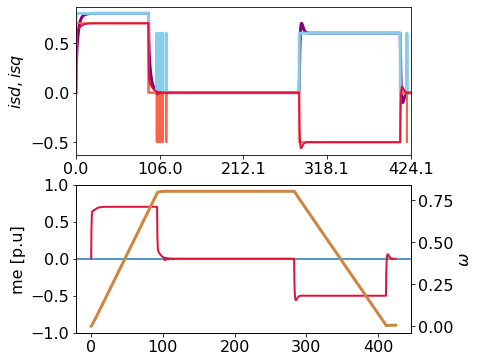

In [105]:
# a = 0.045
Tta, w, me, isd, isq, isdref, isqref = simulateSpeedingUpWithAcceleration()

# print(w)
plotDynamicForSpeedingUp(Tta, w, me, isd, isq, isdref, isqref)

In [ ]:
# a = 0.045
Tta, w, me, isd, isq, isdref, isqref = simulateSpeedingUpWithAcceleration()

# print(w)
plotDynamicForSpeedingUp(Tta, w, me, isd, isq, isdref, isqref)